<h1> Predicting Price </h1>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import re
from sklearn.impute import KNNImputer
pd.set_option('display.float_format', '{:.2f}'.format)
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import pickle

## Reading data

In [3]:
df=pd.read_csv('Cars24_data.csv') # reading previous data

In [4]:
df.head(1)

Name   Price  Rating       city  Kilometers  Year_of_Purchase  \
0   Maruti Alto LXI  174699    4.00  hyderabad       34854              2010   

    Owner Fuel_Type Transmission      RTO Insurance Insurance_Type  \
0  First     Petrol       MANUAL  RTOAP09       NaN        Expired   

  Month_of_Purchase  
0               May

In [5]:
print('shape of data ',df.shape) 

shape of data  (32158, 13)


### Preprocessing columns

### Name

In [6]:
df['Name'].nunique()  # getting unquie cars models  before processing 

2426

In [7]:
# cleaning name column
df['Name']=df['Name'].apply(lambda x:re.sub('[^a-zA-Z0-9 ]','',x)) # including only numbers and alphabets both lower and captils
df['Name']=df['Name'].apply(lambda x:re.sub('\s+',' ',x,)).apply(lambda x:x.upper())# coverting everything to upper case
df['Name']=df['Name'].apply(lambda x:x.strip())

In [8]:
df['Name'].nunique()  # getting unquie cars models  after processing 

2291

### Price

In [9]:
df['Price'].describe() 

count      32158.00
mean      476093.75
std       452149.25
min            1.00
25%       210000.00
50%       368000.00
75%       600000.00
max     10801700.00
Name: Price, dtype: float64

In [10]:
df[df['Price']==1]# since minimum value cannot be 1 we are replacing 1 with some average

Name  Price  Rating  city  Kilometers  \
18606  FIAT LINEA T JET PLUS      1    4.60  pune       31594   

       Year_of_Purchase    Owner Fuel_Type Transmission      RTO   Insurance  \
18606              2014  Second     Petrol          NaN  RTOMH12  20-03-2021   

      Insurance_Type Month_of_Purchase  
18606  Comprehensive             April

In [11]:
df[df['Name'].str.contains('FIAT LINEA T JET PLUS')]

Name   Price  Rating       city  Kilometers  \
9656   FIAT LINEA T JET PLUS  200000    3.90  bengalore       92310   
16291  FIAT LINEA T JET PLUS  212000    4.30       pune       61555   
18606  FIAT LINEA T JET PLUS       1    4.60       pune       31594   

       Year_of_Purchase    Owner     Fuel_Type Transmission      RTO  \
9656               2010   Third   Petrol + LPG          NaN  RTOKA03   
16291              2010  Second         Petrol          NaN  RTOMH12   
18606              2014  Second         Petrol          NaN  RTOMH12   

        Insurance Insurance_Type Month_of_Purchase  
9656   17-10-2021  Comprehensive           October  
16291         NaN        Expired           October  
18606  20-03-2021  Comprehensive             April

In [12]:
df.loc[18606,'Price']=(200000+212000)/2 # replacing min value which 1 with their corresponding average

In [13]:
df['city']=df['city'].replace('bengalore','bangalore') # just spell check

### Filling null values

In [14]:
df['Insurance_Type'].fillna(df['Insurance_Type'].mode()[0], inplace=True)  # filling missing values using mode

In [15]:
df['Transmission'].fillna(df['Transmission'].mode()[0], inplace=True)# filling missing values using mode

In [16]:
df.drop('Insurance',axis=1,inplace=True)# dropping insurance column because it has mostly null values

In [17]:
df.head()

Name     Price  Rating       city  Kilometers  \
0          MARUTI ALTO LXI 174699.00    4.00  hyderabad       34854   
1       MARUTI WAGON R VXI 333999.00    4.20  hyderabad       39541   
2       MARUTI WAGON R VXI 353199.00    4.30  hyderabad       23233   
3  HYUNDAI EON D LITE PLUS 237899.00    4.40  hyderabad       27748   
4     HYUNDAI EON ERA PLUS 300699.00    4.40  hyderabad       12238   

   Year_of_Purchase    Owner Fuel_Type Transmission      RTO Insurance_Type  \
0              2010   First     Petrol       MANUAL  RTOAP09        Expired   
1              2013  Second     Petrol       MANUAL  RTOAP28  Comprehensive   
2              2014  Second     Petrol       MANUAL  RTOAP28  Comprehensive   
3              2013   First     Petrol       MANUAL  RTOAP13  Comprehensive   
4              2017  Second     Petrol       MANUAL  RTOTS10        Expired   

  Month_of_Purchase  
0               May  
1              July  
2             March  
3          November  
4            August

In [18]:
print('checking nan values if any:',df.isnull().values.sum())

checking nan values if any: 0


In [19]:
y_train_df=df['Price']# separating target variable from main dataframe
df.drop('Price',axis=1,inplace=True) # dropping target variable from main data frame
df.head()

Name  Rating       city  Kilometers  Year_of_Purchase  \
0          MARUTI ALTO LXI    4.00  hyderabad       34854              2010   
1       MARUTI WAGON R VXI    4.20  hyderabad       39541              2013   
2       MARUTI WAGON R VXI    4.30  hyderabad       23233              2014   
3  HYUNDAI EON D LITE PLUS    4.40  hyderabad       27748              2013   
4     HYUNDAI EON ERA PLUS    4.40  hyderabad       12238              2017   

     Owner Fuel_Type Transmission      RTO Insurance_Type Month_of_Purchase  
0   First     Petrol       MANUAL  RTOAP09        Expired               May  
1  Second     Petrol       MANUAL  RTOAP28  Comprehensive              July  
2  Second     Petrol       MANUAL  RTOAP28  Comprehensive             March  
3   First     Petrol       MANUAL  RTOAP13  Comprehensive          November  
4  Second     Petrol       MANUAL  RTOTS10        Expired            August

In [20]:
df1=pd.DataFrame(df) # creating dummy duplicate dataframe

In [21]:
df=pd.get_dummies(df,columns=['Name','city','Year_of_Purchase','Owner','Fuel_Type','Transmission','RTO','Insurance_Type','Month_of_Purchase'])
#X_test=pd.get_dummies(X_test,columns=['Name','city','Year_of_Purchase','Owner','Fuel_Type','Transmission','RTO','Insurance_Type','Month_of_Purchase'])

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df, y_train_df, test_size = 0.3,random_state=22)
#X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size = 0.2,random_state=21)

print('Shape of Xtrain ',X_train.shape)
print('Shape of Xtest ',X_test.shape)
print('Shape of ytrain ',y_train.shape)
print('Shape of ytest ',y_test.shape)


Shape of Xtrain  (22510, 3154)
Shape of Xtest  (9648, 3154)
Shape of ytrain  (22510,)
Shape of ytest  (9648,)


In [23]:
def plot_loss_distribu(y_actual,y_pred):
    """Utility funtion which prints metrics and plots distribution of loss value"""
    
    df=pd.DataFrame({'act':y_actual,'pred':y_pred})
    loss = df['act'] - df["pred"] # loss 

    plt.show()
   
    plt.figure(figsize=(15,5))
    plt.title('CDF graph of residuals' ) # plotting cdf of loss
    plt.xlabel('Loss')
    sns.ecdfplot( x=loss )
    
    
    
    plt.figure(figsize=(15,5))
    plt.title('PDF graph of residuals' )  # plotting pdf of loss
    plt.xlabel('Loss')
    plt.hist(loss, bins = int(1800),
             color = 'blue', edgecolor = 'blue')
    plt.show()
    
    print('_'*50)
    print('r2 score :',r2_score(y_actual,y_pred))
    print('mse :',mean_squared_error(y_actual,y_pred))
   
    
   

# Modelling

###  With all features and one hot encoding on categorocal features
###  PART 1

### Linear regression

In [123]:
from sklearn.linear_model import LinearRegression

#parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}

model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

---------=======================------------For train data----------======================--------------


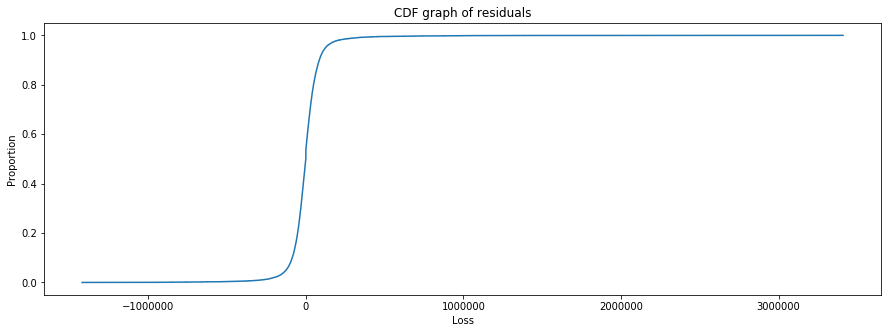

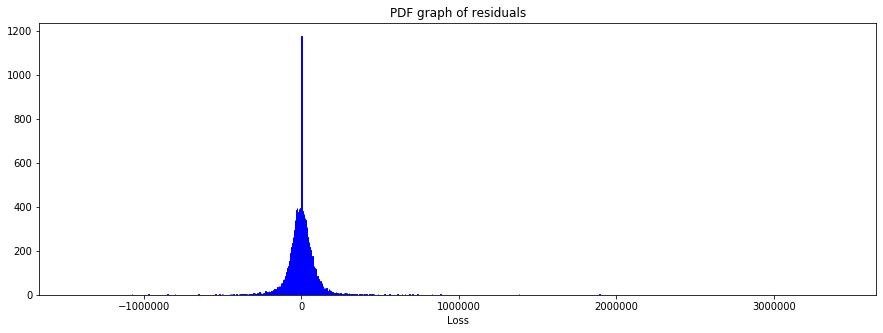

__________________________________________________
r2 score : 0.9308252161489687
mse : 14130000268.617952
---------=======================------------For test data-----------=======================-------------


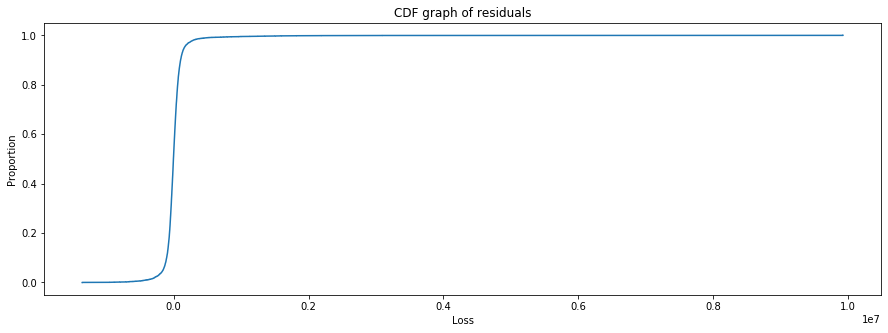

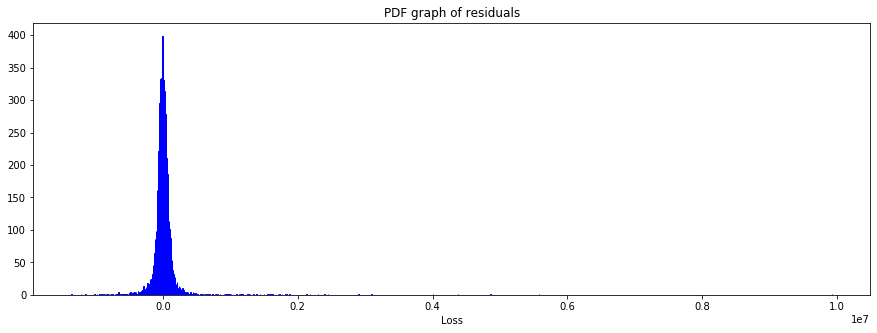

__________________________________________________
r2 score : 0.7710982519258787
mse : 46880664257.56599


In [126]:

y_pred_train=model.predict(X_train)

y_pred = model.predict(X_test)

print('---------=======================------------For train data----------======================--------------')
plot_loss_distribu(y_train,y_pred_train)
print('---------=======================------------For test data-----------=======================-------------')
plot_loss_distribu(y_test,y_pred)



### Linear regression with Log transformation on y_Train

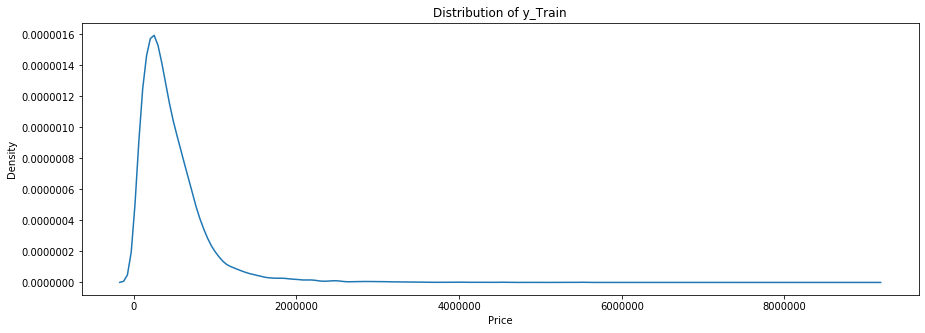

In [40]:
plt.figure(figsize=(15,5))
plt.title('Distribution of y_Train' )
sns.kdeplot(data=y_train, x=y_train)
plt.show()

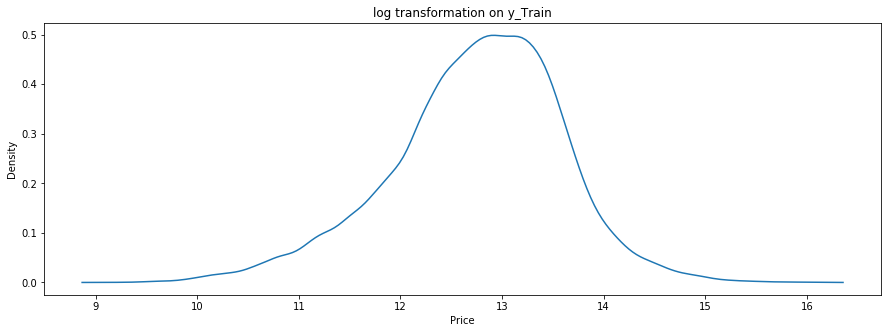

In [42]:
plt.figure(figsize=(15,5))
plt.title('log transformation on y_Train' )
sns.kdeplot(data=y_train, x=np.log(y_train))
plt.show()

In [24]:
from sklearn.linear_model import LinearRegression

#parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}

model = LinearRegression()
model.fit(X_train, np.log(y_train))


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

---------=======================------------For train data----------======================--------------


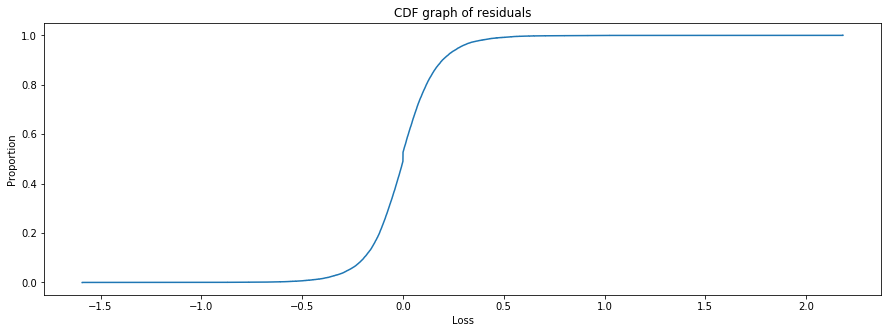

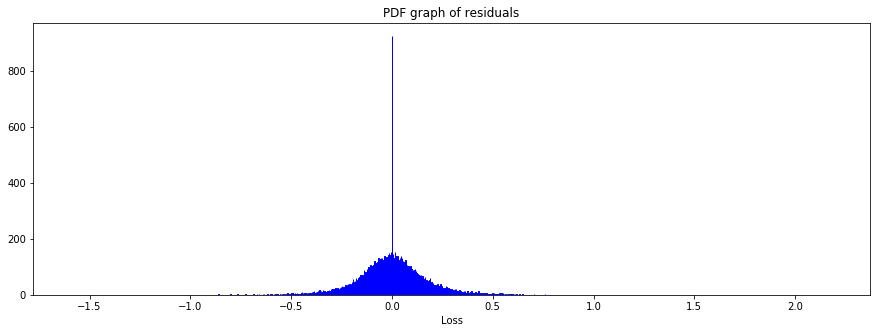

__________________________________________________
r2 score : 0.958718912136373
mse : 0.02960325186305063
---------=======================------------For test data-----------=======================-------------


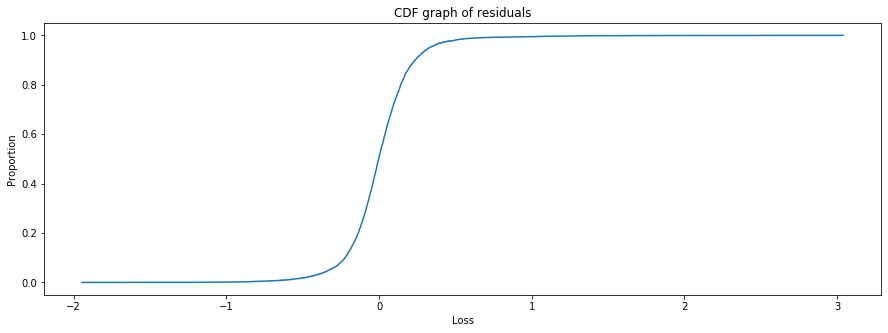

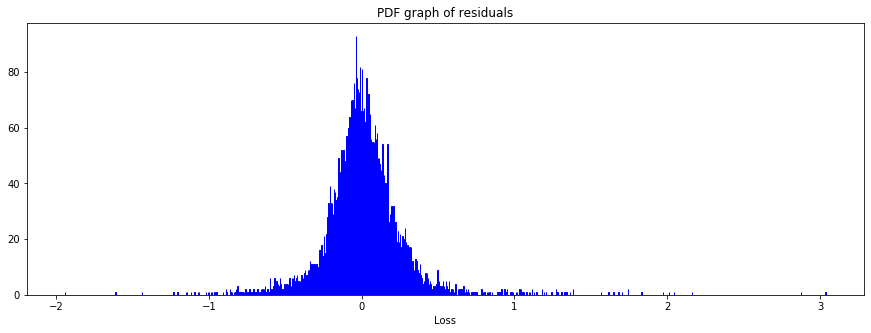

__________________________________________________
r2 score : 0.9239505058255236
mse : 0.0543583769493631


In [26]:

y_pred_train=model.predict(X_train)

y_pred = model.predict(X_test)

print('---------=======================------------For train data----------======================--------------')
plot_loss_distribu(np.log(y_train),y_pred_train)
print('---------=======================------------For test data-----------=======================-------------')
plot_loss_distribu(np.log(y_test),y_pred)



### Decision tree regressor

In [206]:

dtm = DecisionTreeRegressor()

param_grid = {"criterion": ["mse", "mae"],
              "min_samples_split": [10, 20, 40],
              "max_depth": [2, 6, 8],
              "min_samples_leaf": [20, 40, 100],
              "max_leaf_nodes": [5, 20, 100],
              }

## Comment in order to publish in kaggle.

grid_cv_dtm = GridSearchCV(dtm, param_grid, 
                           verbose=2,n_jobs=-1)

grid_cv_dtm.fit(X_train,y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 58.5min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed: 91.8min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['mse', 'mae'], 'max_depth': [2, 6, 8],
                         'max_leaf_nodes': [5, 20, 100],
                   

In [207]:
print('Best parameters obtained after tuning:',grid_cv_dtm.best_params_)

Best parameters obtained after tuning: {'criterion': 'mse', 'max_depth': 8, 'max_leaf_nodes': 100, 'min_samples_leaf': 40, 'min_samples_split': 10}


In [161]:
dt=DecisionTreeRegressor(criterion='mse', max_depth= 8, max_leaf_nodes= 100, min_samples_leaf= 40, min_samples_split= 10)
dt.fit(X_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=8,
                      max_features=None, max_leaf_nodes=100,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=40, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

---------=======================------------For train data----------======================--------------


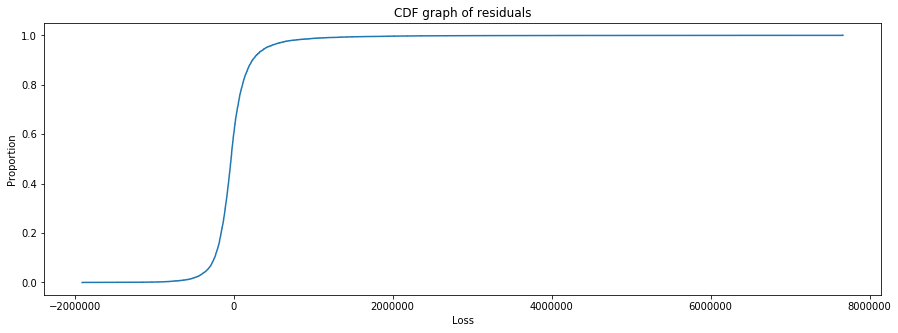

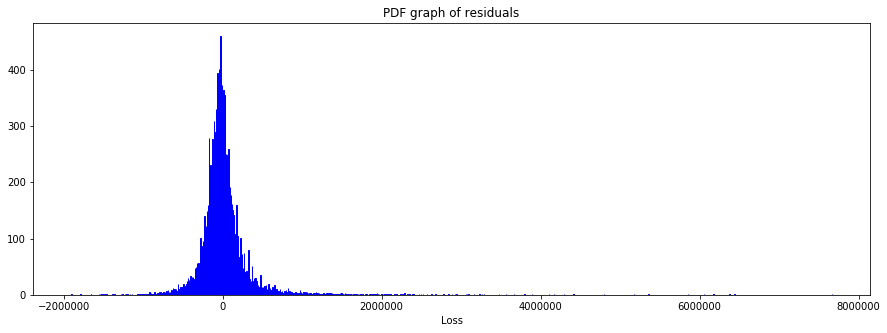

__________________________________________________
r2 score : 0.49093522473576434
mse : 103984212321.0386
---------=======================------------For test data-----------=======================-------------


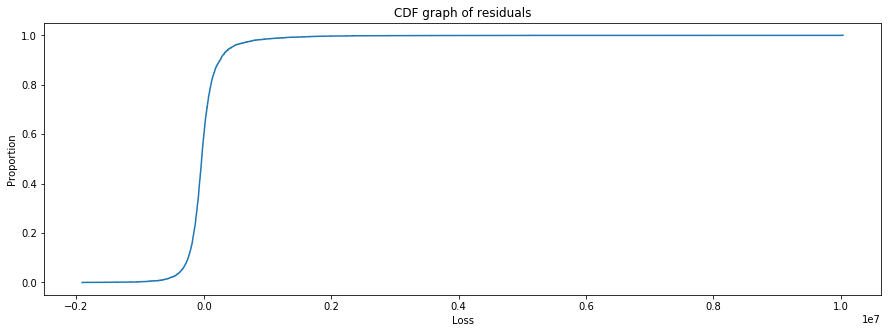

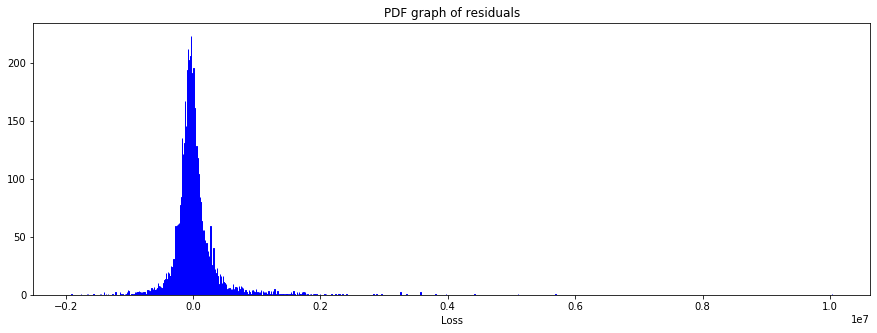

__________________________________________________
r2 score : 0.4477408981328823
mse : 113106491128.38438


In [163]:

y_pred_train=dt.predict(X_train)

y_pred = dt.predict(X_test)

print('---------=======================------------For train data----------======================--------------')
plot_loss_distribu(y_train,y_pred_train)
print('---------=======================------------For test data-----------=======================-------------')
plot_loss_distribu(y_test,y_pred)


filename = 'dt_model.sav'
pickle.dump(dt, open(filename, 'wb'))


In [ ]:
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, y_test)
# print(result)

### 1.3 CatBoostRegressor

In [177]:


categorical_var=[0,2,4,5,6,7,8,9,10]

X_train, X_test, y_train, y_test = train_test_split(df1, y_train_df, test_size = 0.3)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

model = CatBoostRegressor(iterations=2000,
    loss_function = 'RMSE',
    eval_metric = 'R2',
    cat_features = categorical_var )

model.fit( X_train, y_train, use_best_model=True, eval_set=( X_test, y_test), verbose=2, plot=True )

y_pred_train=model.predict(X_train)

y_pred = model.predict(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.053895
0:	learn: 0.0462245	test: 0.0486580	best: 0.0486580 (0)	total: 158ms	remaining: 5m 15s
2:	learn: 0.1246297	test: 0.1310368	best: 0.1310368 (2)	total: 287ms	remaining: 3m 10s
4:	learn: 0.1888234	test: 0.1985001	best: 0.1985001 (4)	total: 512ms	remaining: 3m 24s
6:	learn: 0.2393156	test: 0.2503854	best: 0.2503854 (6)	total: 621ms	remaining: 2m 56s
8:	learn: 0.2859154	test: 0.2981611	best: 0.2981611 (8)	total: 750ms	remaining: 2m 45s
10:	learn: 0.3315639	test: 0.3458814	best: 0.3458814 (10)	total: 931ms	remaining: 2m 48s
12:	learn: 0.3688038	test: 0.3854184	best: 0.3854184 (12)	total: 1.08s	remaining: 2m 45s
14:	learn: 0.3982815	test: 0.4170750	best: 0.4170750 (14)	total: 1.18s	remaining: 2m 36s
16:	learn: 0.4255605	test: 0.4445273	best: 0.4445273 (16)	total: 1.29s	remaining: 2m 30s
18:	learn: 0.4471890	test: 0.4668794	best: 0.4668794 (18)	total: 1.39s	remaining: 2m 25s
20:	learn: 0.4643238	test: 0.4842941	best: 0.4842941 (20)	total: 1.5s	remaining: 2m 21s
22

184:	learn: 0.6022595	test: 0.6088609	best: 0.6088609 (184)	total: 9.74s	remaining: 1m 35s
186:	learn: 0.6028198	test: 0.6091492	best: 0.6091492 (186)	total: 9.89s	remaining: 1m 35s
188:	learn: 0.6029304	test: 0.6091667	best: 0.6091667 (188)	total: 10s	remaining: 1m 36s
190:	learn: 0.6031389	test: 0.6091879	best: 0.6091879 (190)	total: 10.1s	remaining: 1m 35s
192:	learn: 0.6035228	test: 0.6092007	best: 0.6092007 (192)	total: 10.2s	remaining: 1m 35s
194:	learn: 0.6038303	test: 0.6091329	best: 0.6092029 (193)	total: 10.3s	remaining: 1m 35s
196:	learn: 0.6045161	test: 0.6096301	best: 0.6096301 (196)	total: 10.4s	remaining: 1m 35s
198:	learn: 0.6046653	test: 0.6096599	best: 0.6096599 (198)	total: 10.5s	remaining: 1m 34s
200:	learn: 0.6050112	test: 0.6097261	best: 0.6097415 (199)	total: 10.6s	remaining: 1m 34s
202:	learn: 0.6052880	test: 0.6097761	best: 0.6097761 (202)	total: 10.7s	remaining: 1m 34s
204:	learn: 0.6056828	test: 0.6100909	best: 0.6100909 (204)	total: 10.8s	remaining: 1m 34s
2

370:	learn: 0.6319270	test: 0.6176644	best: 0.6176678 (369)	total: 18.4s	remaining: 1m 20s
372:	learn: 0.6322486	test: 0.6176249	best: 0.6176678 (369)	total: 18.5s	remaining: 1m 20s
374:	learn: 0.6324591	test: 0.6176021	best: 0.6176678 (369)	total: 18.6s	remaining: 1m 20s
376:	learn: 0.6325256	test: 0.6175898	best: 0.6176678 (369)	total: 18.6s	remaining: 1m 20s
378:	learn: 0.6328652	test: 0.6176425	best: 0.6176678 (369)	total: 18.7s	remaining: 1m 20s
380:	learn: 0.6333413	test: 0.6175579	best: 0.6176678 (369)	total: 18.8s	remaining: 1m 19s
382:	learn: 0.6336990	test: 0.6176222	best: 0.6176678 (369)	total: 18.9s	remaining: 1m 19s
384:	learn: 0.6338756	test: 0.6176927	best: 0.6176927 (384)	total: 19s	remaining: 1m 19s
386:	learn: 0.6342060	test: 0.6178430	best: 0.6178430 (386)	total: 19.1s	remaining: 1m 19s
388:	learn: 0.6342428	test: 0.6178431	best: 0.6178431 (388)	total: 19.2s	remaining: 1m 19s
390:	learn: 0.6343563	test: 0.6178872	best: 0.6178872 (390)	total: 19.3s	remaining: 1m 19s
3

552:	learn: 0.6546303	test: 0.6227290	best: 0.6227290 (552)	total: 27.1s	remaining: 1m 11s
554:	learn: 0.6548213	test: 0.6227213	best: 0.6227534 (553)	total: 27.2s	remaining: 1m 10s
556:	learn: 0.6551058	test: 0.6227919	best: 0.6227919 (556)	total: 27.3s	remaining: 1m 10s
558:	learn: 0.6552035	test: 0.6228131	best: 0.6228131 (558)	total: 27.4s	remaining: 1m 10s
560:	learn: 0.6554697	test: 0.6227943	best: 0.6228131 (558)	total: 27.5s	remaining: 1m 10s
562:	learn: 0.6555092	test: 0.6228088	best: 0.6228131 (558)	total: 27.7s	remaining: 1m 10s
564:	learn: 0.6558454	test: 0.6228236	best: 0.6228389 (563)	total: 27.8s	remaining: 1m 10s
566:	learn: 0.6559499	test: 0.6227824	best: 0.6228389 (563)	total: 27.8s	remaining: 1m 10s
568:	learn: 0.6563143	test: 0.6229358	best: 0.6229358 (568)	total: 27.9s	remaining: 1m 10s
570:	learn: 0.6563729	test: 0.6229453	best: 0.6229453 (570)	total: 28s	remaining: 1m 10s
572:	learn: 0.6565365	test: 0.6229652	best: 0.6229652 (572)	total: 28.1s	remaining: 1m 10s
5

736:	learn: 0.6726388	test: 0.6255051	best: 0.6256649 (725)	total: 36.5s	remaining: 1m 2s
738:	learn: 0.6727963	test: 0.6256066	best: 0.6256649 (725)	total: 36.6s	remaining: 1m 2s
740:	learn: 0.6730245	test: 0.6258182	best: 0.6258182 (740)	total: 36.7s	remaining: 1m 2s
742:	learn: 0.6730662	test: 0.6257885	best: 0.6258182 (740)	total: 36.8s	remaining: 1m 2s
744:	learn: 0.6731133	test: 0.6257531	best: 0.6258182 (740)	total: 36.9s	remaining: 1m 2s
746:	learn: 0.6731901	test: 0.6257113	best: 0.6258182 (740)	total: 37s	remaining: 1m 2s
748:	learn: 0.6735738	test: 0.6255554	best: 0.6258182 (740)	total: 37.2s	remaining: 1m 2s
750:	learn: 0.6737656	test: 0.6255560	best: 0.6258182 (740)	total: 37.3s	remaining: 1m 2s
752:	learn: 0.6741887	test: 0.6255892	best: 0.6258182 (740)	total: 37.4s	remaining: 1m 1s
754:	learn: 0.6744251	test: 0.6256805	best: 0.6258182 (740)	total: 37.5s	remaining: 1m 1s
756:	learn: 0.6748095	test: 0.6257833	best: 0.6258182 (740)	total: 37.6s	remaining: 1m 1s
758:	learn: 

920:	learn: 0.6895280	test: 0.6276312	best: 0.6278921 (899)	total: 46.3s	remaining: 54.2s
922:	learn: 0.6897461	test: 0.6277667	best: 0.6278921 (899)	total: 46.3s	remaining: 54.1s
924:	learn: 0.6899648	test: 0.6277615	best: 0.6278921 (899)	total: 46.4s	remaining: 54s
926:	learn: 0.6900176	test: 0.6277517	best: 0.6278921 (899)	total: 46.5s	remaining: 53.9s
928:	learn: 0.6902333	test: 0.6277941	best: 0.6278921 (899)	total: 46.6s	remaining: 53.8s
930:	learn: 0.6905595	test: 0.6277791	best: 0.6278921 (899)	total: 46.8s	remaining: 53.7s
932:	learn: 0.6909559	test: 0.6277932	best: 0.6278921 (899)	total: 46.9s	remaining: 53.6s
934:	learn: 0.6910811	test: 0.6279180	best: 0.6279180 (934)	total: 47s	remaining: 53.5s
936:	learn: 0.6913052	test: 0.6280757	best: 0.6280757 (936)	total: 47.1s	remaining: 53.4s
938:	learn: 0.6913458	test: 0.6280670	best: 0.6280757 (936)	total: 47.2s	remaining: 53.3s
940:	learn: 0.6915679	test: 0.6281020	best: 0.6281020 (940)	total: 47.3s	remaining: 53.2s
942:	learn: 0.

1102:	learn: 0.7058666	test: 0.6295646	best: 0.6295646 (1102)	total: 55.7s	remaining: 45.3s
1104:	learn: 0.7059180	test: 0.6295600	best: 0.6295646 (1102)	total: 55.8s	remaining: 45.2s
1106:	learn: 0.7059746	test: 0.6295407	best: 0.6295646 (1102)	total: 55.8s	remaining: 45s
1108:	learn: 0.7062418	test: 0.6295494	best: 0.6295646 (1102)	total: 55.9s	remaining: 44.9s
1110:	learn: 0.7063533	test: 0.6295342	best: 0.6295646 (1102)	total: 56s	remaining: 44.8s
1112:	learn: 0.7064532	test: 0.6295260	best: 0.6295646 (1102)	total: 56.1s	remaining: 44.7s
1114:	learn: 0.7067053	test: 0.6295959	best: 0.6295959 (1114)	total: 56.2s	remaining: 44.6s
1116:	learn: 0.7068892	test: 0.6296150	best: 0.6296302 (1115)	total: 56.3s	remaining: 44.5s
1118:	learn: 0.7069315	test: 0.6296269	best: 0.6296302 (1115)	total: 56.4s	remaining: 44.4s
1120:	learn: 0.7069814	test: 0.6296462	best: 0.6296462 (1120)	total: 56.5s	remaining: 44.3s
1122:	learn: 0.7072051	test: 0.6296470	best: 0.6297109 (1121)	total: 56.7s	remaining

1282:	learn: 0.7189723	test: 0.6295778	best: 0.6301834 (1154)	total: 1m 5s	remaining: 36.4s
1284:	learn: 0.7191020	test: 0.6295303	best: 0.6301834 (1154)	total: 1m 5s	remaining: 36.3s
1286:	learn: 0.7193354	test: 0.6296196	best: 0.6301834 (1154)	total: 1m 5s	remaining: 36.2s
1288:	learn: 0.7194279	test: 0.6296320	best: 0.6301834 (1154)	total: 1m 5s	remaining: 36.1s
1290:	learn: 0.7195017	test: 0.6296732	best: 0.6301834 (1154)	total: 1m 5s	remaining: 36s
1292:	learn: 0.7198677	test: 0.6297258	best: 0.6301834 (1154)	total: 1m 5s	remaining: 35.9s
1294:	learn: 0.7199497	test: 0.6297156	best: 0.6301834 (1154)	total: 1m 5s	remaining: 35.8s
1296:	learn: 0.7202747	test: 0.6297157	best: 0.6301834 (1154)	total: 1m 5s	remaining: 35.7s
1298:	learn: 0.7203680	test: 0.6297068	best: 0.6301834 (1154)	total: 1m 5s	remaining: 35.6s
1300:	learn: 0.7204806	test: 0.6296787	best: 0.6301834 (1154)	total: 1m 6s	remaining: 35.5s
1302:	learn: 0.7206359	test: 0.6297334	best: 0.6301834 (1154)	total: 1m 6s	remaini

1460:	learn: 0.7340223	test: 0.6295481	best: 0.6301834 (1154)	total: 1m 14s	remaining: 27.5s
1462:	learn: 0.7341444	test: 0.6296340	best: 0.6301834 (1154)	total: 1m 14s	remaining: 27.4s
1464:	learn: 0.7341807	test: 0.6296260	best: 0.6301834 (1154)	total: 1m 14s	remaining: 27.3s
1466:	learn: 0.7344268	test: 0.6296800	best: 0.6301834 (1154)	total: 1m 14s	remaining: 27.1s
1468:	learn: 0.7346462	test: 0.6296917	best: 0.6301834 (1154)	total: 1m 14s	remaining: 27s
1470:	learn: 0.7349778	test: 0.6299973	best: 0.6301834 (1154)	total: 1m 14s	remaining: 26.9s
1472:	learn: 0.7350616	test: 0.6300174	best: 0.6301834 (1154)	total: 1m 15s	remaining: 26.8s
1474:	learn: 0.7352328	test: 0.6300107	best: 0.6301834 (1154)	total: 1m 15s	remaining: 26.7s
1476:	learn: 0.7353709	test: 0.6302759	best: 0.6302759 (1476)	total: 1m 15s	remaining: 26.7s
1478:	learn: 0.7354131	test: 0.6303082	best: 0.6303082 (1478)	total: 1m 15s	remaining: 26.6s
1480:	learn: 0.7354679	test: 0.6303046	best: 0.6303094 (1479)	total: 1m 

1638:	learn: 0.7454222	test: 0.6317888	best: 0.6319188 (1629)	total: 1m 23s	remaining: 18.4s
1640:	learn: 0.7456477	test: 0.6318307	best: 0.6319188 (1629)	total: 1m 23s	remaining: 18.3s
1642:	learn: 0.7457842	test: 0.6317939	best: 0.6319188 (1629)	total: 1m 23s	remaining: 18.2s
1644:	learn: 0.7458628	test: 0.6318888	best: 0.6319188 (1629)	total: 1m 24s	remaining: 18.1s
1646:	learn: 0.7459751	test: 0.6318049	best: 0.6319188 (1629)	total: 1m 24s	remaining: 18.1s
1648:	learn: 0.7461430	test: 0.6317100	best: 0.6319188 (1629)	total: 1m 24s	remaining: 18s
1650:	learn: 0.7462622	test: 0.6317155	best: 0.6319188 (1629)	total: 1m 24s	remaining: 17.9s
1652:	learn: 0.7464549	test: 0.6316851	best: 0.6319188 (1629)	total: 1m 24s	remaining: 17.8s
1654:	learn: 0.7465572	test: 0.6316901	best: 0.6319188 (1629)	total: 1m 24s	remaining: 17.7s
1656:	learn: 0.7466578	test: 0.6317287	best: 0.6319188 (1629)	total: 1m 24s	remaining: 17.6s
1658:	learn: 0.7467528	test: 0.6317713	best: 0.6319188 (1629)	total: 1m 

1818:	learn: 0.7558822	test: 0.6319923	best: 0.6323437 (1768)	total: 1m 34s	remaining: 9.42s
1820:	learn: 0.7559658	test: 0.6320128	best: 0.6323437 (1768)	total: 1m 34s	remaining: 9.31s
1822:	learn: 0.7560439	test: 0.6319683	best: 0.6323437 (1768)	total: 1m 34s	remaining: 9.21s
1824:	learn: 0.7561629	test: 0.6319820	best: 0.6323437 (1768)	total: 1m 34s	remaining: 9.1s
1826:	learn: 0.7562331	test: 0.6319158	best: 0.6323437 (1768)	total: 1m 35s	remaining: 9s
1828:	learn: 0.7564529	test: 0.6319374	best: 0.6323437 (1768)	total: 1m 35s	remaining: 8.9s
1830:	learn: 0.7566287	test: 0.6319258	best: 0.6323437 (1768)	total: 1m 35s	remaining: 8.8s
1832:	learn: 0.7567982	test: 0.6319894	best: 0.6323437 (1768)	total: 1m 35s	remaining: 8.71s
1834:	learn: 0.7568972	test: 0.6320199	best: 0.6323437 (1768)	total: 1m 35s	remaining: 8.6s
1836:	learn: 0.7569576	test: 0.6320085	best: 0.6323437 (1768)	total: 1m 35s	remaining: 8.5s
1838:	learn: 0.7570357	test: 0.6319871	best: 0.6323437 (1768)	total: 1m 35s	re

1996:	learn: 0.7660667	test: 0.6322623	best: 0.6323618 (1986)	total: 1m 49s	remaining: 164ms
1998:	learn: 0.7662149	test: 0.6323206	best: 0.6323618 (1986)	total: 1m 49s	remaining: 54.8ms
1999:	learn: 0.7664611	test: 0.6324797	best: 0.6324797 (1999)	total: 1m 49s	remaining: 0us

bestTest = 0.6324797227
bestIteration = 1999



---------=======================------------For train data----------======================--------------


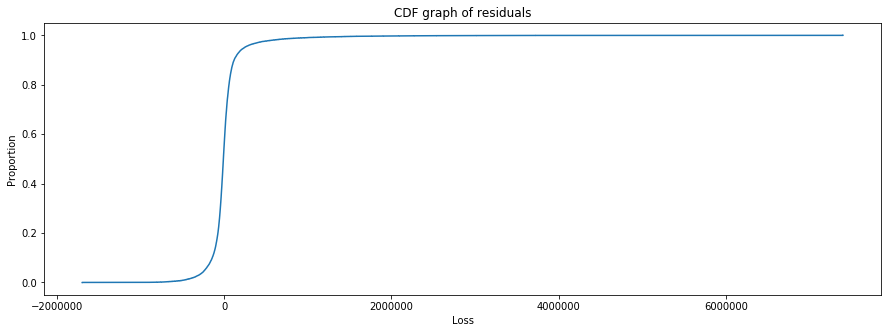

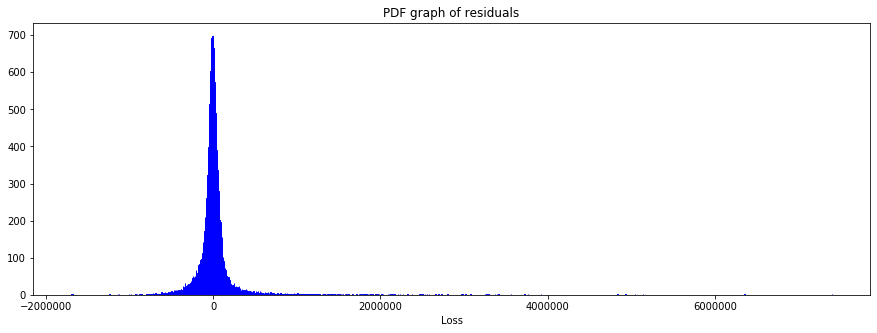

__________________________________________________
r2 score : 0.6965959939315436
mse : 62511307703.2799
---------=======================------------For test data-----------=======================-------------


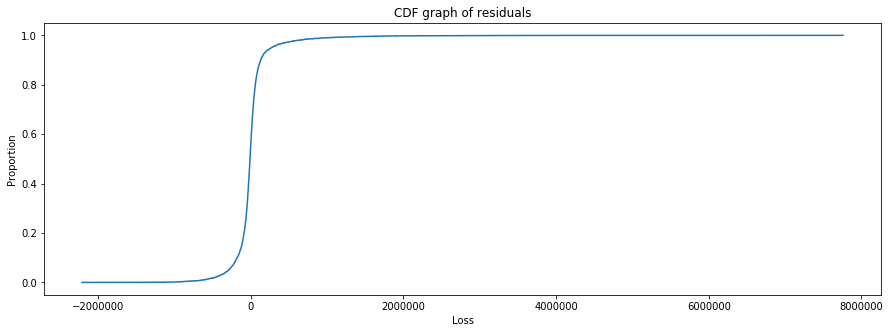

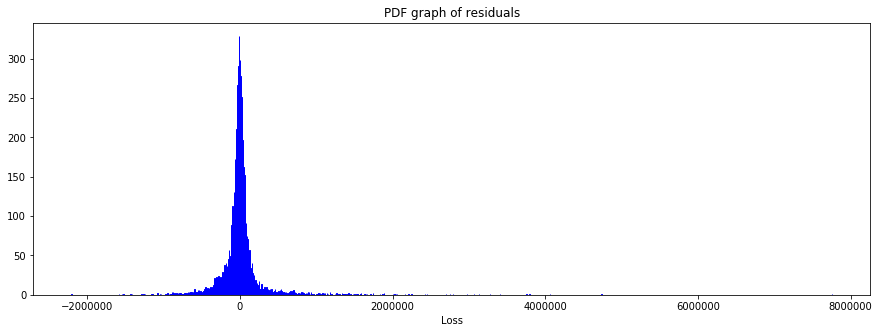

__________________________________________________
r2 score : 0.6324797227037711
mse : 73752718532.23149


In [178]:
print('---------=======================------------For train data----------======================--------------')
plot_loss_distribu(y_train,y_pred_train)
print('---------=======================------------For test data-----------=======================-------------')
plot_loss_distribu(y_test,y_pred)



# -----------------------------------------------------------------------------------------------------

## Feature encoding on Name column with all features included

## Part 2

In [45]:
df2=pd.get_dummies(df1,columns=['city','Year_of_Purchase','Owner','Fuel_Type','Transmission','RTO','Insurance_Type','Month_of_Purchase'])

In [46]:
X_train, X_test, y_train, y_test = train_test_split(df2, y_train_df, test_size = 0.3,random_state=22)


In [47]:
def frequency_encod(Name,df,df2) :  
    """this function implements frequency counting for every class for particular categorical feature"""
    fe=(df.groupby(Name).size()) 
   # print(fe)
    return df2[Name].map(fe)

In [48]:
# applying feature encoding for name column
X_train['Name']=frequency_encod('Name',df1,df1)
X_test['Name']=frequency_encod('Name',df1,df1)


C:\Users\santosh\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\santosh\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [49]:
X_train.head()# printing dataframe after feature encoding name column

Name  Rating  Kilometers Company_and_year  city_ahmedabad  \
19836    61    4.30       37388       HONDA 2016               0   
8823     46    3.70       61165      MARUTI 2011               0   
275      58    3.50       72131     HYUNDAI 2006               0   
29858     8    3.50      158389  MITSUBISHI 1999               0   
4981     63    3.80      141131      MARUTI 2016               0   

       city_bangalore  city_chandigarh  city_chennai  city_hyderabad  \
19836               0                0             0               0   
8823                1                0             0               0   
275                 0                0             0               1   
29858               0                0             0               0   
4981                0                0             0               1   

       city_jaipur  ...  Month_of_Purchase_December  \
19836            0  ...                           0   
8823             0  ...                           0   
275              0  ...                           0   
29858            1  ...                           0   
4981             0  ...                           0   

       Month_of_Purchase_February  Month_of_Purchase_January  \
19836                           0                          1   
8823                            0                          0   
275                             0                          1   
29858                           0                          0   
4981                            0                          0   

       Month_of_Purchase_July  Month_of_Purchase_June  \
19836                       0                       0   
8823                        0                       0   
275                         0                       0   
29858                       0                       0   
4981                        0                       0   

       Month_of_Purchase_March  Month_of_Purchase_May  \
19836                        0                      0   
8823                         0                      1   
275                          0                      0   
29858                        0                      0   
4981                         0                      0   

       Month_of_Purchase_November  Month_of_Purchase_October  \
19836                           0                          0   
8823                            0                          0   
275                             0                          0   
29858                           1                          0   
4981                            0                          0   

       Month_of_Purchase_September  
19836                            0  
8823                             0  
275                              0  
29858                            0  
4981                             0  

[5 rows x 865 columns]

###  2.1 DecisionTreeRegressor

In [163]:
from sklearn.tree import DecisionTreeRegressor
dtm = DecisionTreeRegressor()

param_grid = {"criterion": ["mse", "mae"],
              "min_samples_split": [5,10, 20, 40],
              "max_depth": [2, 5,15,20,35],
              "min_samples_leaf": [20, 30,40, ],
              "max_leaf_nodes": [5, 20, 100],
              }

## Comment in order to publish in kaggle.

grid_cv_dtm = GridSearchCV(dtm, param_grid, 
                           verbose=2,n_jobs=-2)

grid_cv_dtm.fit(X_train,y_train)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-2)]: Done 351 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-2)]: Done 634 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-2)]: Done 999 tasks      | elapsed: 19.1min
[Parallel(n_jobs=-2)]: Done 1444 tasks      | elapsed: 90.6min
[Parallel(n_jobs=-2)]: Done 1800 out of 1800 | elapsed: 148.9min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=-2,
             param_grid={'criterion': ['mse', 'mae'],
                         'max_depth': [2, 5, 15, 20, 35],
                         'max_leaf_nodes':

In [164]:
print('Best parameters obtained after tuning:',grid_cv_dtm.best_params_)

Best parameters obtained after tuning: {'criterion': 'mse', 'max_depth': 15, 'max_leaf_nodes': 100, 'min_samples_leaf': 40, 'min_samples_split': 5}


In [170]:
dt=DecisionTreeRegressor(criterion='mse', max_depth= 15, max_leaf_nodes= 100, min_samples_leaf= 40, min_samples_split= 5)
dt.fit(X_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=15,
                      max_features=None, max_leaf_nodes=100,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=40, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

---------=======================------------For train data----------======================--------------


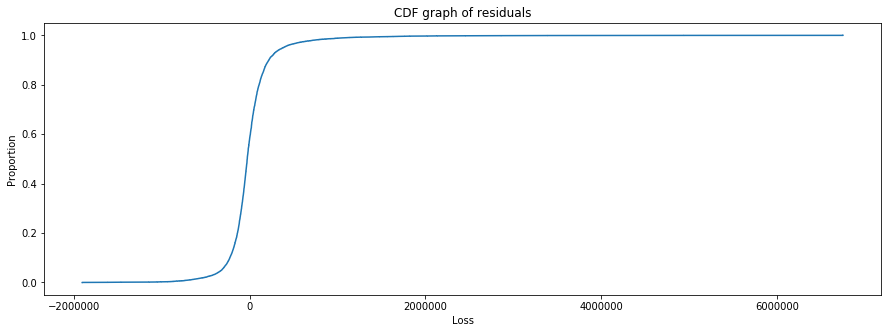

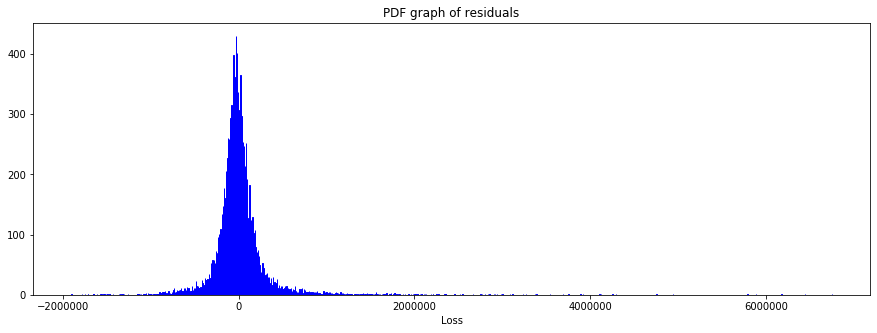

__________________________________________________
r2 score : 0.5345053759493255
mse : 95084347166.74847
---------=======================------------For test data-----------=======================-------------


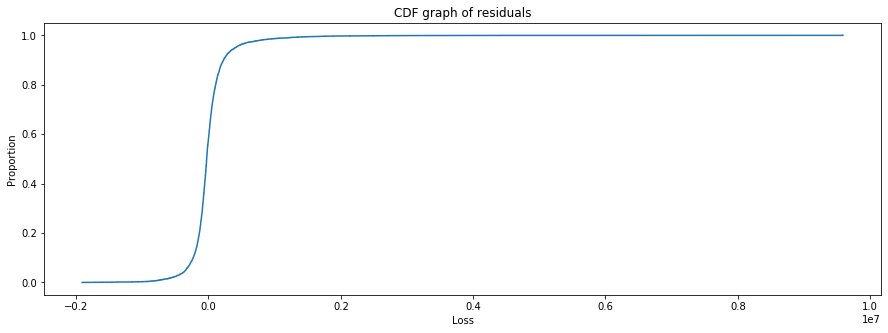

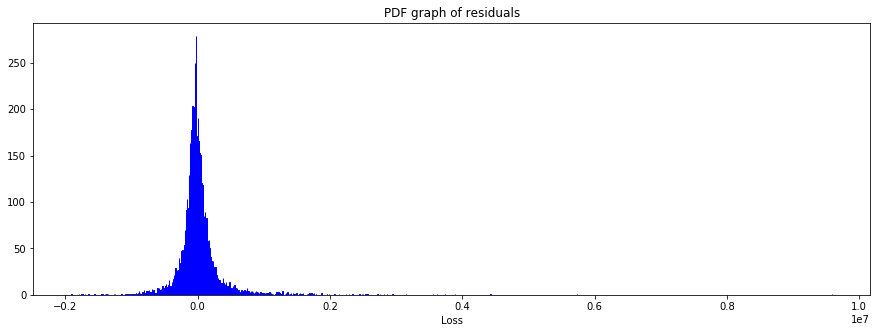

__________________________________________________
r2 score : 0.4888706578670612
mse : 104682831312.26091


In [171]:

y_pred_train=dt.predict(X_train)

y_pred = dt.predict(X_test)

print('---------=======================------------For train data----------======================--------------')
plot_loss_distribu(y_train,y_pred_train)
print('---------=======================------------For test data-----------=======================-------------')
plot_loss_distribu(y_test,y_pred)


filename = 'dt_model1.sav'
pickle.dump(dt, open(filename, 'wb'))


###  2.2 RandomForestRegressor

In [170]:
%%time

RF = RandomForestRegressor()

parameters = {'n_estimators': [10, 100, 500, 1000], 'max_depth':[3,4,5,6,7,8,9,10,11,15],"min_samples_leaf": [20, 40, 100]}

clf = GridSearchCV(RF, parameters, cv= 2, verbose=2,n_jobs=-2)

clf.fit(X_train, y_train)



Fitting 2 folds for each of 120 candidates, totalling 240 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed: 38.6min
[Parallel(n_jobs=-2)]: Done 240 out of 240 | elapsed: 77.8min finished


Wall time: 1h 26min 43s


In [171]:
print('Best parameters obtained after tuning:',clf.best_params_)

Best parameters obtained after tuning: {'max_depth': 15, 'min_samples_leaf': 20, 'n_estimators': 1000}


In [174]:
RF = RandomForestRegressor(max_depth=15, min_samples_leaf= 20, n_estimators= 1000)
RF.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=20,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

---------=======================------------For train data----------======================--------------


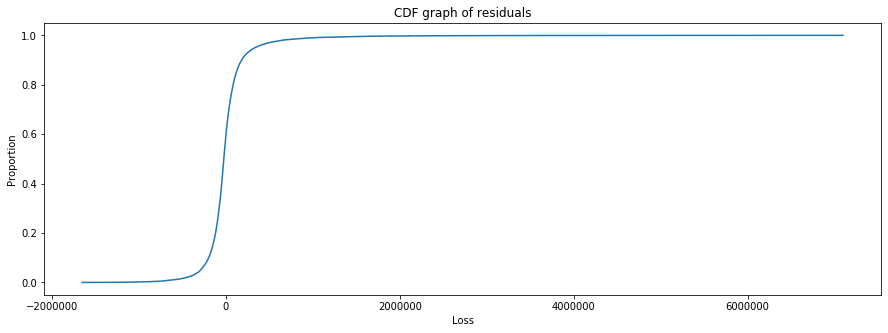

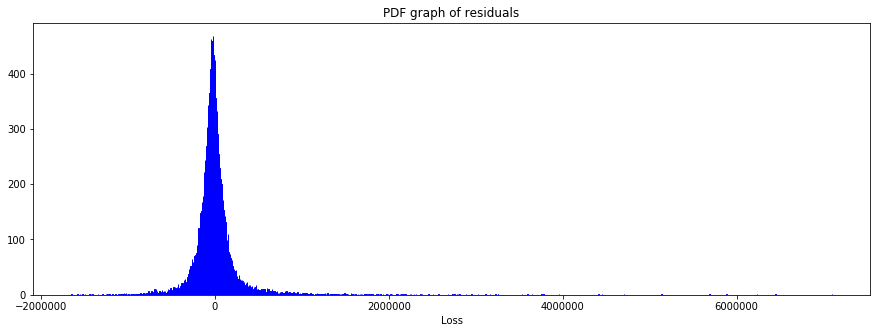

__________________________________________________
r2 score : 0.5990286987060407
mse : 81904478475.75412
---------=======================------------For test data-----------=======================-------------


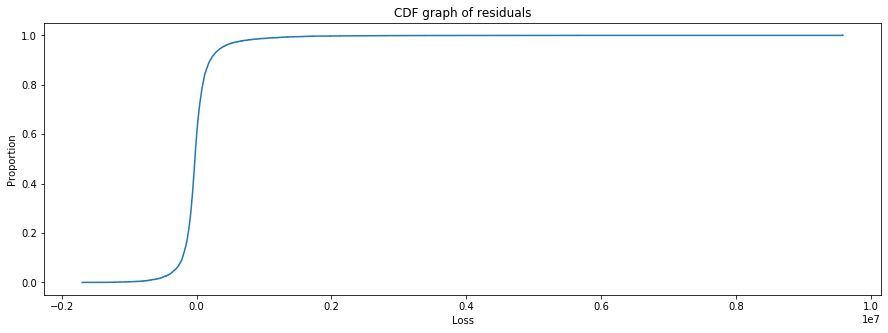

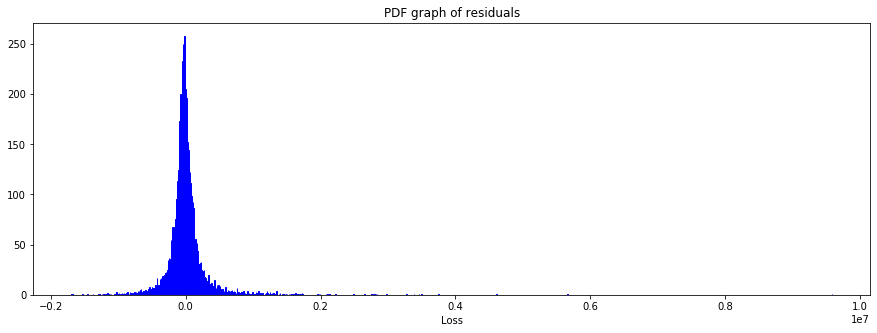

__________________________________________________
r2 score : 0.5360627776426737
mse : 95017558148.48004


In [175]:

y_pred_train=RF.predict(X_train)

y_pred = RF.predict(X_test)

print('---------=======================------------For train data----------======================--------------')
plot_loss_distribu(y_train,y_pred_train)
print('---------=======================------------For test data-----------=======================-------------')
plot_loss_distribu(y_test,y_pred)


filename = 'rf_model1.sav'
pickle.dump(dt, open(filename, 'wb'))


# --------------------------------------------------------------------------------------------------------------

## PART 3

### columns:

#### first two words in name column

### CatBoost 

In [50]:
df1['Model']='' # creating new column named model
for k,i in enumerate(df1['Name']):
    df1.loc[k,'Model']=' '.join(i.split()[:2]) # Splitting and taking first two letters
    

In [51]:
df3=df1.drop(['Name'],1) # dropping Name column
df3.head()

Rating       city  Kilometers  Year_of_Purchase    Owner Fuel_Type  \
0    4.00  hyderabad       34854              2010   First     Petrol   
1    4.20  hyderabad       39541              2013  Second     Petrol   
2    4.30  hyderabad       23233              2014  Second     Petrol   
3    4.40  hyderabad       27748              2013   First     Petrol   
4    4.40  hyderabad       12238              2017  Second     Petrol   

  Transmission      RTO Insurance_Type Month_of_Purchase Company_and_year  \
0       MANUAL  RTOAP09        Expired               May      MARUTI 2010   
1       MANUAL  RTOAP28  Comprehensive              July      MARUTI 2013   
2       MANUAL  RTOAP28  Comprehensive             March      MARUTI 2014   
3       MANUAL  RTOAP13  Comprehensive          November     HYUNDAI 2013   
4       MANUAL  RTOTS10        Expired            August     HYUNDAI 2017   

          Model  
0   MARUTI ALTO  
1  MARUTI WAGON  
2  MARUTI WAGON  
3   HYUNDAI EON  
4   HYUNDAI EON

In [42]:
categorical_var=[1,3,4,5,6,7,8,9,10]


X_train, X_test, y_train, y_test = train_test_split(df3, y_train_df, test_size = 0.3,random_state=21)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

model = CatBoostRegressor(iterations=1000,
    loss_function = 'RMSE',
    eval_metric = 'R2',
    cat_features = categorical_var )

model.fit( X_train, y_train, use_best_model=True, eval_set=( X_test, y_test), verbose=2, plot=True )

y_pred_train=model.predict(X_train)

y_pred = model.predict(X_test)



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.083002
0:	learn: 0.0828351	test: 0.0827412	best: 0.0827412 (0)	total: 40ms	remaining: 40s
2:	learn: 0.2127518	test: 0.2135657	best: 0.2135657 (2)	total: 120ms	remaining: 39.9s
4:	learn: 0.3064097	test: 0.3092731	best: 0.3092731 (4)	total: 196ms	remaining: 39s
6:	learn: 0.3723732	test: 0.3746317	best: 0.3746317 (6)	total: 272ms	remaining: 38.6s
8:	learn: 0.4247628	test: 0.4292222	best: 0.4292222 (8)	total: 328ms	remaining: 36.1s
10:	learn: 0.4743761	test: 0.4797303	best: 0.4797303 (10)	total: 387ms	remaining: 34.8s
12:	learn: 0.5151498	test: 0.5215751	best: 0.5215751 (12)	total: 478ms	remaining: 36.3s
14:	learn: 0.5424546	test: 0.5491304	best: 0.5491304 (14)	total: 529ms	remaining: 34.7s
16:	learn: 0.5625698	test: 0.5701967	best: 0.5701967 (16)	total: 584ms	remaining: 33.8s
18:	learn: 0.5816594	test: 0.5895006	best: 0.5895006 (18)	total: 663ms	remaining: 34.2s
20:	learn: 0.6019882	test: 0.6102531	best: 0.6102531 (20)	total: 724ms	remaining: 33.8s
22:	learn: 0.6139

188:	learn: 0.7974099	test: 0.7764422	best: 0.7767336 (182)	total: 7.96s	remaining: 34.1s
190:	learn: 0.7981493	test: 0.7760643	best: 0.7767336 (182)	total: 8.03s	remaining: 34s
192:	learn: 0.7984489	test: 0.7759697	best: 0.7767336 (182)	total: 8.12s	remaining: 34s
194:	learn: 0.7991413	test: 0.7757248	best: 0.7767336 (182)	total: 8.19s	remaining: 33.8s
196:	learn: 0.8001135	test: 0.7766934	best: 0.7767336 (182)	total: 8.26s	remaining: 33.7s
198:	learn: 0.8004784	test: 0.7765161	best: 0.7767668 (197)	total: 8.33s	remaining: 33.5s
200:	learn: 0.8009971	test: 0.7766147	best: 0.7767668 (197)	total: 8.39s	remaining: 33.4s
202:	learn: 0.8012427	test: 0.7765292	best: 0.7767668 (197)	total: 8.47s	remaining: 33.2s
204:	learn: 0.8019491	test: 0.7770280	best: 0.7770280 (204)	total: 8.54s	remaining: 33.1s
206:	learn: 0.8023295	test: 0.7767651	best: 0.7770280 (204)	total: 8.66s	remaining: 33.2s
208:	learn: 0.8026938	test: 0.7769538	best: 0.7770415 (207)	total: 8.75s	remaining: 33.1s
210:	learn: 0.

372:	learn: 0.8408825	test: 0.7921315	best: 0.7922519 (369)	total: 15.1s	remaining: 25.4s
374:	learn: 0.8411899	test: 0.7919422	best: 0.7922519 (369)	total: 15.2s	remaining: 25.3s
376:	learn: 0.8413947	test: 0.7919507	best: 0.7922519 (369)	total: 15.3s	remaining: 25.2s
378:	learn: 0.8417263	test: 0.7919960	best: 0.7922519 (369)	total: 15.3s	remaining: 25.1s
380:	learn: 0.8420857	test: 0.7919912	best: 0.7922519 (369)	total: 15.4s	remaining: 25.1s
382:	learn: 0.8422606	test: 0.7919581	best: 0.7922519 (369)	total: 15.5s	remaining: 25s
384:	learn: 0.8426300	test: 0.7920282	best: 0.7922519 (369)	total: 15.6s	remaining: 24.9s
386:	learn: 0.8427215	test: 0.7920487	best: 0.7922519 (369)	total: 15.7s	remaining: 24.8s
388:	learn: 0.8428747	test: 0.7920115	best: 0.7922519 (369)	total: 15.8s	remaining: 24.7s
390:	learn: 0.8430061	test: 0.7920116	best: 0.7922519 (369)	total: 15.8s	remaining: 24.7s
392:	learn: 0.8431356	test: 0.7919954	best: 0.7922519 (369)	total: 15.9s	remaining: 24.6s
394:	learn: 

556:	learn: 0.8610877	test: 0.7996231	best: 0.7996231 (556)	total: 23s	remaining: 18.3s
558:	learn: 0.8613553	test: 0.7997856	best: 0.7997856 (558)	total: 23.1s	remaining: 18.2s
560:	learn: 0.8614370	test: 0.7997840	best: 0.7997856 (558)	total: 23.2s	remaining: 18.1s
562:	learn: 0.8615027	test: 0.7997906	best: 0.7997906 (562)	total: 23.2s	remaining: 18s
564:	learn: 0.8616593	test: 0.7997970	best: 0.7997970 (564)	total: 23.3s	remaining: 18s
566:	learn: 0.8617213	test: 0.7997736	best: 0.7997970 (564)	total: 23.4s	remaining: 17.9s
568:	learn: 0.8617984	test: 0.7997734	best: 0.7997970 (564)	total: 23.5s	remaining: 17.8s
570:	learn: 0.8620631	test: 0.7998549	best: 0.7998549 (570)	total: 23.5s	remaining: 17.7s
572:	learn: 0.8621642	test: 0.7998999	best: 0.7998999 (572)	total: 23.6s	remaining: 17.6s
574:	learn: 0.8623102	test: 0.7999588	best: 0.7999588 (574)	total: 23.7s	remaining: 17.5s
576:	learn: 0.8623686	test: 0.7999718	best: 0.7999718 (576)	total: 23.8s	remaining: 17.5s
578:	learn: 0.86

742:	learn: 0.8742154	test: 0.8016112	best: 0.8017234 (734)	total: 30.4s	remaining: 10.5s
744:	learn: 0.8743049	test: 0.8016539	best: 0.8017234 (734)	total: 30.5s	remaining: 10.4s
746:	learn: 0.8744280	test: 0.8016294	best: 0.8017234 (734)	total: 30.6s	remaining: 10.4s
748:	learn: 0.8744870	test: 0.8016573	best: 0.8017234 (734)	total: 30.7s	remaining: 10.3s
750:	learn: 0.8745356	test: 0.8016839	best: 0.8017234 (734)	total: 30.8s	remaining: 10.2s
752:	learn: 0.8745835	test: 0.8016828	best: 0.8017234 (734)	total: 30.9s	remaining: 10.1s
754:	learn: 0.8746314	test: 0.8016988	best: 0.8017234 (734)	total: 30.9s	remaining: 10s
756:	learn: 0.8747220	test: 0.8016534	best: 0.8017234 (734)	total: 31s	remaining: 9.95s
758:	learn: 0.8747506	test: 0.8016710	best: 0.8017234 (734)	total: 31.1s	remaining: 9.88s
760:	learn: 0.8750375	test: 0.8016214	best: 0.8017234 (734)	total: 31.2s	remaining: 9.79s
762:	learn: 0.8751006	test: 0.8016785	best: 0.8017234 (734)	total: 31.3s	remaining: 9.72s
764:	learn: 0.

930:	learn: 0.8846625	test: 0.8039005	best: 0.8039005 (930)	total: 38.3s	remaining: 2.84s
932:	learn: 0.8847094	test: 0.8038952	best: 0.8039035 (931)	total: 38.4s	remaining: 2.76s
934:	learn: 0.8850103	test: 0.8041897	best: 0.8041897 (934)	total: 38.5s	remaining: 2.67s
936:	learn: 0.8850737	test: 0.8041836	best: 0.8041897 (934)	total: 38.6s	remaining: 2.6s
938:	learn: 0.8850933	test: 0.8041883	best: 0.8041897 (934)	total: 38.7s	remaining: 2.51s
940:	learn: 0.8851474	test: 0.8041820	best: 0.8041897 (934)	total: 38.8s	remaining: 2.43s
942:	learn: 0.8852738	test: 0.8042943	best: 0.8042943 (942)	total: 38.8s	remaining: 2.35s
944:	learn: 0.8854131	test: 0.8043153	best: 0.8043153 (944)	total: 38.9s	remaining: 2.26s
946:	learn: 0.8854639	test: 0.8042711	best: 0.8043153 (944)	total: 39s	remaining: 2.18s
948:	learn: 0.8855418	test: 0.8042783	best: 0.8043153 (944)	total: 39.1s	remaining: 2.1s
950:	learn: 0.8856794	test: 0.8042956	best: 0.8043153 (944)	total: 39.2s	remaining: 2.02s
952:	learn: 0.

---------=======================------------For train data----------======================--------------


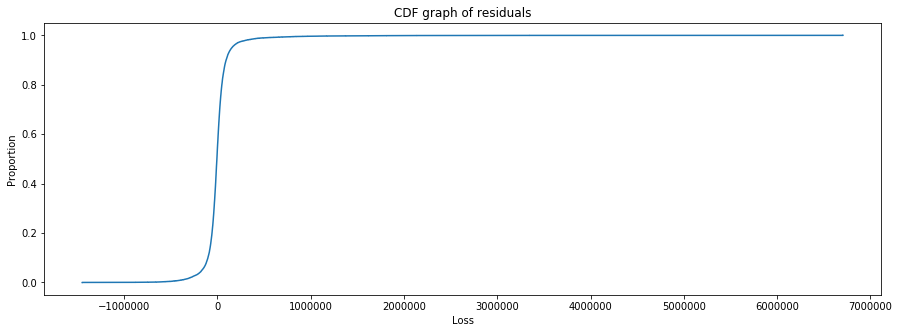

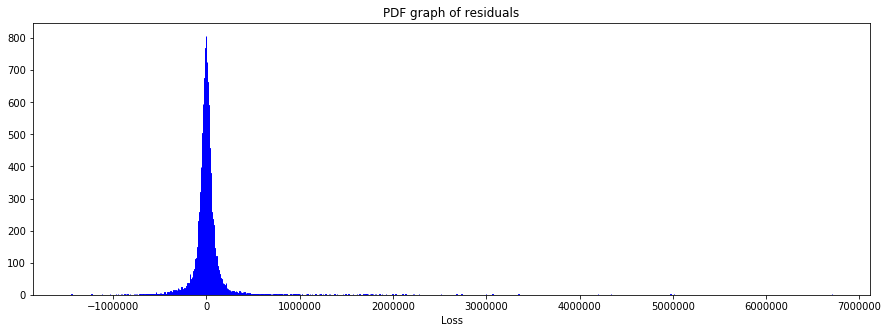

__________________________________________________
r2 score : 0.8498179496694224
mse : 30792735281.098568
---------=======================------------For test data-----------=======================-------------


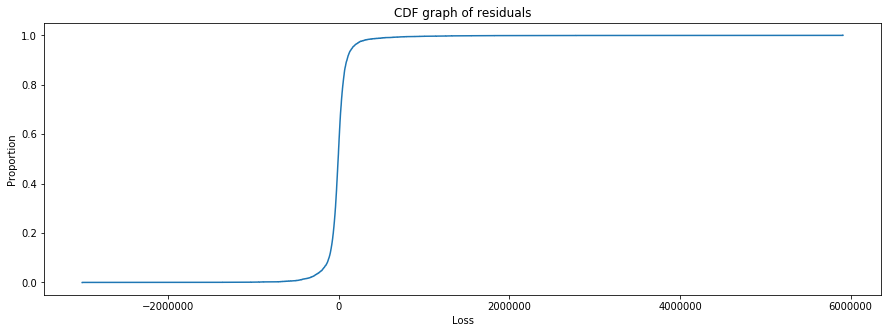

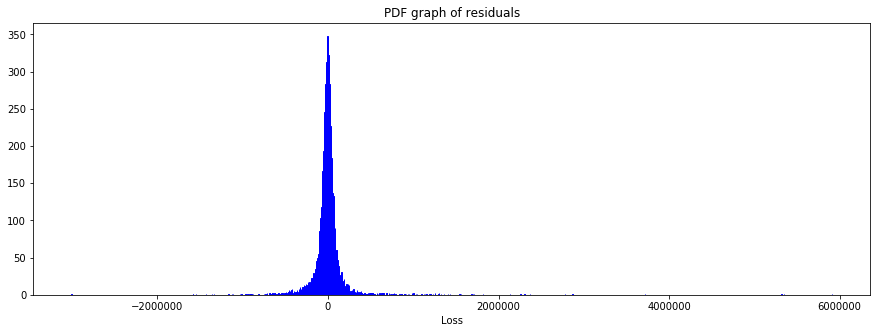

__________________________________________________
r2 score : 0.8055492239134572
mse : 39475171231.67402


In [43]:
print('---------=======================------------For train data----------======================--------------')
plot_loss_distribu(y_train,y_pred_train)
print('---------=======================------------For test data-----------=======================-------------')
plot_loss_distribu(y_test,y_pred)



# --------------------------------------------------------------------------------------------------------------

## Part 4

### Columns:
#### company name+ model first two words

### CatBoost 

In [52]:
df1['Company']=''
for k,i in enumerate(df1['Name']):
    df1.loc[k,'Company']=i.split()[0]

In [53]:
df4=df1.drop(['Name'],1)
df4.head()

Rating       city  Kilometers  Year_of_Purchase    Owner Fuel_Type  \
0    4.00  hyderabad       34854              2010   First     Petrol   
1    4.20  hyderabad       39541              2013  Second     Petrol   
2    4.30  hyderabad       23233              2014  Second     Petrol   
3    4.40  hyderabad       27748              2013   First     Petrol   
4    4.40  hyderabad       12238              2017  Second     Petrol   

  Transmission      RTO Insurance_Type Month_of_Purchase Company_and_year  \
0       MANUAL  RTOAP09        Expired               May      MARUTI 2010   
1       MANUAL  RTOAP28  Comprehensive              July      MARUTI 2013   
2       MANUAL  RTOAP28  Comprehensive             March      MARUTI 2014   
3       MANUAL  RTOAP13  Comprehensive          November     HYUNDAI 2013   
4       MANUAL  RTOTS10        Expired            August     HYUNDAI 2017   

          Model  Company  
0   MARUTI ALTO   MARUTI  
1  MARUTI WAGON   MARUTI  
2  MARUTI WAGON   MARUTI  
3   HYUNDAI EON  HYUNDAI  
4   HYUNDAI EON  HYUNDAI

In [51]:
#datam=df.drop(['Name','Price','Insurance','Company_and_year','Model'],1)

In [52]:
datam.isnull().sum()

Rating               0
city                 0
Kilometers           0
Year_of_Purchase     0
Owner                0
Fuel_Type            0
Transmission         0
RTO                  0
Insurance_Type       0
Month_of_Purchase    0
Company              0
dtype: int64

In [48]:
categorical_var=[1,3,4,5,6,7,8,9,10,11]


X_train, X_test, y_train, y_test = train_test_split(df4, y_train_df, test_size = 0.3,random_state=21)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

model = CatBoostRegressor(iterations=1000,
    loss_function = 'RMSE',
    eval_metric = 'R2',
    cat_features = categorical_var )

model.fit( X_train, y_train, use_best_model=True, eval_set=( X_test, y_test), verbose=2, plot=True )

y_pred_train=model.predict(X_train)

y_pred = model.predict(X_test)



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.083002
0:	learn: 0.0982141	test: 0.0968226	best: 0.0968226 (0)	total: 37.8ms	remaining: 37.8s
2:	learn: 0.2595989	test: 0.2591575	best: 0.2591575 (2)	total: 114ms	remaining: 37.8s
4:	learn: 0.3839540	test: 0.3819642	best: 0.3819642 (4)	total: 188ms	remaining: 37.4s
6:	learn: 0.4737045	test: 0.4706436	best: 0.4706436 (6)	total: 271ms	remaining: 38.5s
8:	learn: 0.5410959	test: 0.5352480	best: 0.5352480 (8)	total: 331ms	remaining: 36.4s
10:	learn: 0.5921733	test: 0.5791754	best: 0.5791754 (10)	total: 394ms	remaining: 35.4s
12:	learn: 0.6322655	test: 0.6155812	best: 0.6155812 (12)	total: 468ms	remaining: 35.5s
14:	learn: 0.6622491	test: 0.6443865	best: 0.6443865 (14)	total: 521ms	remaining: 34.2s
16:	learn: 0.6861156	test: 0.6650183	best: 0.6650183 (16)	total: 601ms	remaining: 34.8s
18:	learn: 0.7063264	test: 0.6826540	best: 0.6826540 (18)	total: 733ms	remaining: 37.9s
20:	learn: 0.7230012	test: 0.6978290	best: 0.6978290 (20)	total: 865ms	remaining: 40.3s
22:	learn: 

188:	learn: 0.8702686	test: 0.8207081	best: 0.8207081 (188)	total: 8.59s	remaining: 36.9s
190:	learn: 0.8703425	test: 0.8207492	best: 0.8207492 (190)	total: 8.67s	remaining: 36.7s
192:	learn: 0.8710880	test: 0.8215986	best: 0.8215986 (192)	total: 8.75s	remaining: 36.6s
194:	learn: 0.8714189	test: 0.8216253	best: 0.8216253 (194)	total: 8.82s	remaining: 36.4s
196:	learn: 0.8722959	test: 0.8218553	best: 0.8218695 (195)	total: 8.9s	remaining: 36.3s
198:	learn: 0.8725517	test: 0.8218706	best: 0.8218706 (198)	total: 8.97s	remaining: 36.1s
200:	learn: 0.8729367	test: 0.8218551	best: 0.8219474 (199)	total: 9.04s	remaining: 35.9s
202:	learn: 0.8732077	test: 0.8217983	best: 0.8219474 (199)	total: 9.11s	remaining: 35.8s
204:	learn: 0.8735211	test: 0.8222721	best: 0.8222721 (204)	total: 9.19s	remaining: 35.7s
206:	learn: 0.8743885	test: 0.8223471	best: 0.8223471 (206)	total: 9.28s	remaining: 35.5s
208:	learn: 0.8745598	test: 0.8223946	best: 0.8223946 (208)	total: 9.35s	remaining: 35.4s
210:	learn:

376:	learn: 0.8995582	test: 0.8289297	best: 0.8289516 (374)	total: 16.6s	remaining: 27.4s
378:	learn: 0.8997815	test: 0.8290430	best: 0.8290430 (378)	total: 16.7s	remaining: 27.3s
380:	learn: 0.8999202	test: 0.8291474	best: 0.8291474 (380)	total: 16.7s	remaining: 27.2s
382:	learn: 0.9000799	test: 0.8291999	best: 0.8291999 (382)	total: 16.8s	remaining: 27.1s
384:	learn: 0.9003060	test: 0.8293419	best: 0.8293419 (384)	total: 16.9s	remaining: 27s
386:	learn: 0.9004183	test: 0.8292653	best: 0.8293444 (385)	total: 17s	remaining: 26.9s
388:	learn: 0.9005177	test: 0.8292298	best: 0.8293444 (385)	total: 17.1s	remaining: 26.8s
390:	learn: 0.9007375	test: 0.8292817	best: 0.8293444 (385)	total: 17.2s	remaining: 26.7s
392:	learn: 0.9009634	test: 0.8294010	best: 0.8294010 (392)	total: 17.2s	remaining: 26.6s
394:	learn: 0.9012676	test: 0.8296387	best: 0.8296387 (394)	total: 17.3s	remaining: 26.5s
396:	learn: 0.9014367	test: 0.8296448	best: 0.8296448 (396)	total: 17.5s	remaining: 26.6s
398:	learn: 0.

562:	learn: 0.9159617	test: 0.8333120	best: 0.8333138 (560)	total: 24.9s	remaining: 19.3s
564:	learn: 0.9160854	test: 0.8332175	best: 0.8333138 (560)	total: 25s	remaining: 19.3s
566:	learn: 0.9161651	test: 0.8331777	best: 0.8333138 (560)	total: 25.1s	remaining: 19.2s
568:	learn: 0.9164163	test: 0.8331277	best: 0.8333138 (560)	total: 25.2s	remaining: 19.1s
570:	learn: 0.9165192	test: 0.8332061	best: 0.8333138 (560)	total: 25.2s	remaining: 19s
572:	learn: 0.9166830	test: 0.8333008	best: 0.8333138 (560)	total: 25.3s	remaining: 18.9s
574:	learn: 0.9167966	test: 0.8332555	best: 0.8333138 (560)	total: 25.4s	remaining: 18.8s
576:	learn: 0.9169394	test: 0.8333539	best: 0.8333539 (576)	total: 25.5s	remaining: 18.7s
578:	learn: 0.9170218	test: 0.8334145	best: 0.8334145 (578)	total: 25.6s	remaining: 18.6s
580:	learn: 0.9170716	test: 0.8334316	best: 0.8334316 (580)	total: 25.7s	remaining: 18.5s
582:	learn: 0.9172252	test: 0.8333835	best: 0.8334316 (580)	total: 25.8s	remaining: 18.4s
584:	learn: 0.

750:	learn: 0.9274090	test: 0.8355462	best: 0.8355552 (749)	total: 32.8s	remaining: 10.9s
752:	learn: 0.9275249	test: 0.8356293	best: 0.8356293 (752)	total: 33s	remaining: 10.8s
754:	learn: 0.9276134	test: 0.8356649	best: 0.8356649 (754)	total: 33s	remaining: 10.7s
756:	learn: 0.9277645	test: 0.8357194	best: 0.8357195 (755)	total: 33.1s	remaining: 10.6s
758:	learn: 0.9279411	test: 0.8356716	best: 0.8357195 (755)	total: 33.2s	remaining: 10.5s
760:	learn: 0.9280683	test: 0.8359040	best: 0.8359040 (760)	total: 33.3s	remaining: 10.4s
762:	learn: 0.9281682	test: 0.8359052	best: 0.8359203 (761)	total: 33.3s	remaining: 10.4s
764:	learn: 0.9282428	test: 0.8359157	best: 0.8359203 (761)	total: 33.4s	remaining: 10.3s
766:	learn: 0.9284261	test: 0.8359966	best: 0.8359966 (766)	total: 33.5s	remaining: 10.2s
768:	learn: 0.9284900	test: 0.8359570	best: 0.8359966 (766)	total: 33.6s	remaining: 10.1s
770:	learn: 0.9286019	test: 0.8360494	best: 0.8360494 (770)	total: 33.7s	remaining: 10s
772:	learn: 0.92

934:	learn: 0.9362712	test: 0.8376892	best: 0.8379274 (911)	total: 40.8s	remaining: 2.84s
936:	learn: 0.9363193	test: 0.8377035	best: 0.8379274 (911)	total: 40.9s	remaining: 2.75s
938:	learn: 0.9364750	test: 0.8378129	best: 0.8379274 (911)	total: 41s	remaining: 2.66s
940:	learn: 0.9366226	test: 0.8377866	best: 0.8379274 (911)	total: 41.1s	remaining: 2.58s
942:	learn: 0.9366956	test: 0.8378866	best: 0.8379274 (911)	total: 41.2s	remaining: 2.49s
944:	learn: 0.9368362	test: 0.8378519	best: 0.8379274 (911)	total: 41.2s	remaining: 2.4s
946:	learn: 0.9369156	test: 0.8379370	best: 0.8379370 (946)	total: 41.3s	remaining: 2.31s
948:	learn: 0.9370183	test: 0.8378674	best: 0.8379370 (946)	total: 41.4s	remaining: 2.22s
950:	learn: 0.9371493	test: 0.8379657	best: 0.8379657 (950)	total: 41.5s	remaining: 2.14s
952:	learn: 0.9372883	test: 0.8379678	best: 0.8379678 (952)	total: 41.6s	remaining: 2.05s
954:	learn: 0.9373461	test: 0.8379801	best: 0.8379858 (953)	total: 41.7s	remaining: 1.96s
956:	learn: 0

---------=======================------------For train data----------======================--------------


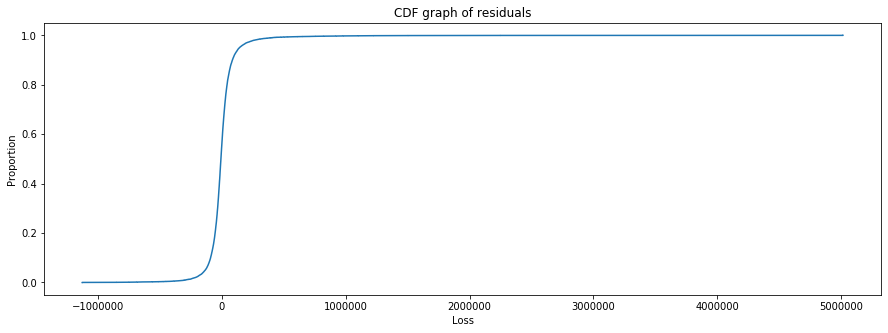

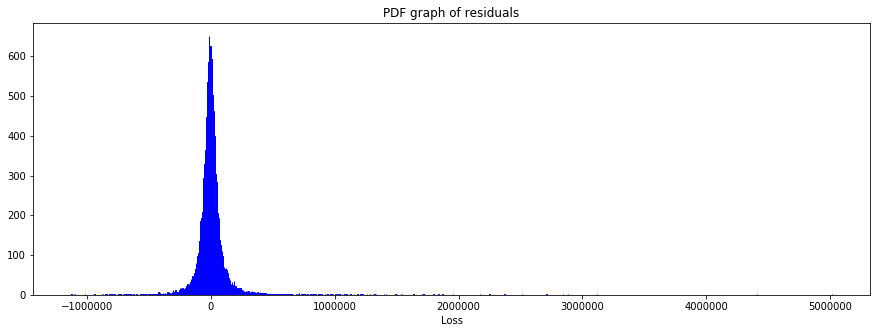

__________________________________________________
r2 score : 0.9056194261887345
mse : 19351420616.853584
---------=======================------------For test data-----------=======================-------------


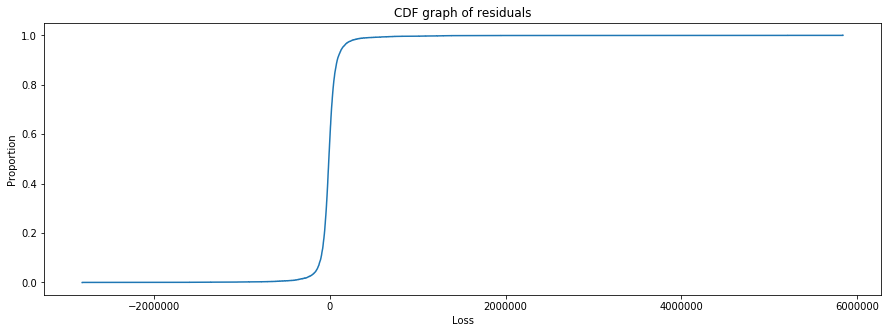

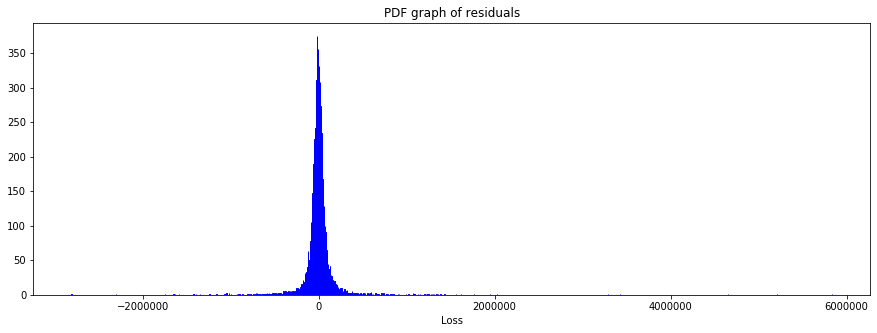

__________________________________________________
r2 score : 0.8383518467554104
mse : 32815958141.375946


In [49]:
print('---------=======================------------For train data----------======================--------------')
plot_loss_distribu(y_train,y_pred_train)
print('---------=======================------------For test data-----------=======================-------------')
plot_loss_distribu(y_test,y_pred)


### XGB 

In [50]:
df4.head(1)

Rating       city  Kilometers  Year_of_Purchase   Owner Fuel_Type  \
0    4.00  hyderabad       34854              2010  First     Petrol   

  Transmission      RTO Insurance_Type Month_of_Purchase        Model Company  
0       MANUAL  RTOAP09        Expired               May  MARUTI ALTO  MARUTI

In [51]:
df4=pd.get_dummies(df4,columns=['city','Year_of_Purchase','Owner','Fuel_Type','Transmission','RTO','Insurance_Type','Month_of_Purchase','Company','Model'])

In [53]:
X_train, X_test, y_train, y_test = train_test_split(df4, y_train_df, test_size = 0.3,random_state=21)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((22510, 1115), (9648, 1115), (22510,), (9648,))

In [58]:
gsc = GridSearchCV(
        estimator=xgb_model,
        param_grid={#'colsample_bytree' : [0.1, 0.3, 0.4],
            #'gamma': [0.0, 0.1, 0.2],
            'n_estimators':[50,100,150],
            'learning_rate': [0.3,0.35,0.4],
            'max_depth': [7,9]
            
                   },
        cv=3, scoring='r2', verbose=5, n_jobs=-2)

In [59]:
grid_result = gsc.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-2)]: Done  52 out of  54 | elapsed: 39.1min remaining:  1.5min
[Parallel(n_jobs=-2)]: Done  54 out of  54 | elapsed: 40.0min finished
C:\Users\santosh\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [62]:
grid_result.best_params_

{'learning_rate': 0.35, 'max_depth': 7, 'n_estimators': 150}

In [63]:
xgb_model =XGBRegressor(learning_rate= 0.35, max_depth=7, n_estimators= 150,objective="reg:squarederror", random_state=21)

xgb_model.fit(X_train, y_train)

y_pred_train=xgb_model.predict(X_train)

y_pred = xgb_model.predict(X_test)



C:\Users\santosh\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


---------=======================------------For train data----------======================--------------


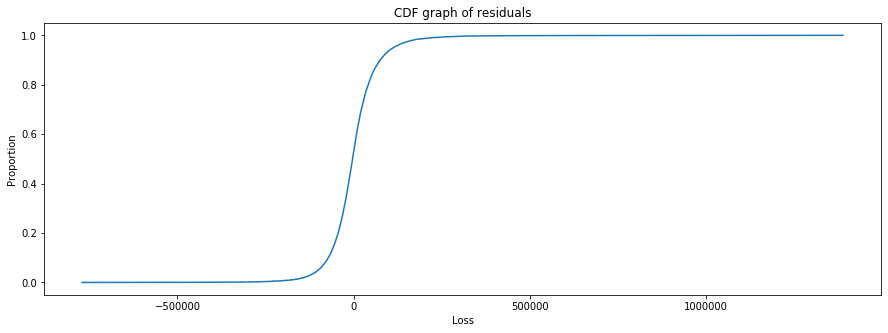

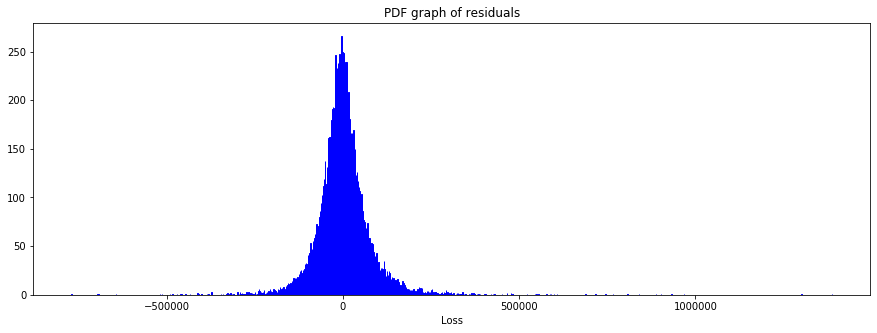

__________________________________________________
r2 score : 0.9732781035605157
mse : 5478952254.671931
---------=======================------------For test data-----------=======================-------------


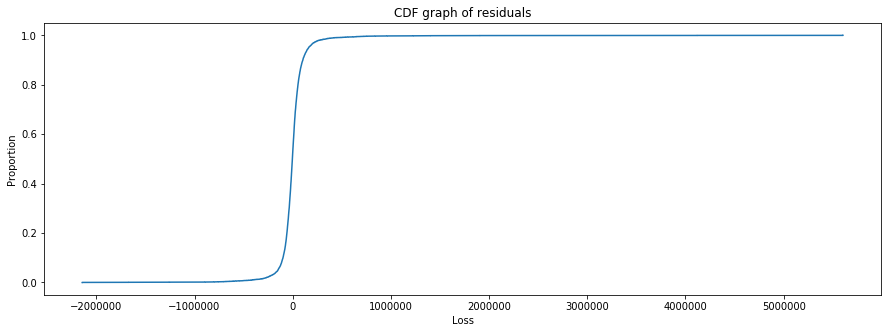

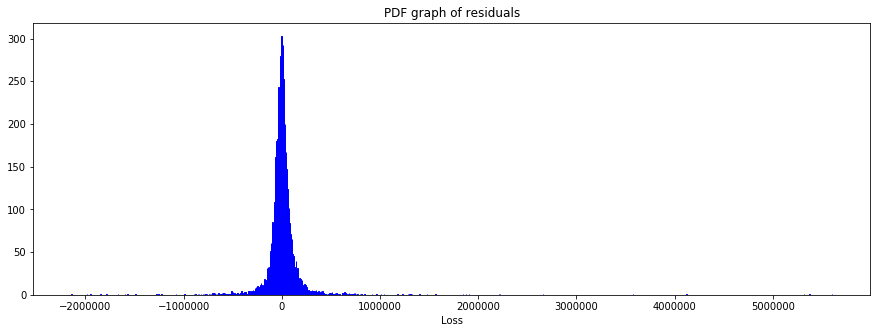

__________________________________________________
r2 score : 0.8276883743289467
mse : 34980734278.71336


In [64]:
print('---------=======================------------For train data----------======================--------------')
plot_loss_distribu(y_train,y_pred_train)
print('---------=======================------------For test data-----------=======================-------------')
plot_loss_distribu(y_test,y_pred)


# --------------------------------------------------------------------------------------------------------

## Part 5

### Columns:
#### company name+ model first two words+company and year combined

### Catboost with log transformation on target variable

In [54]:
df1['Company_and_year']=''
    
for k,i in enumerate(df1['Name']):
    df1.loc[k,'Company_and_year']=i.split()[0]+' '+str(df1['Year_of_Purchase'][k])
    
df5=df1.drop(['Name'],1)
df5.head()

Rating       city  Kilometers  Year_of_Purchase    Owner Fuel_Type  \
0    4.00  hyderabad       34854              2010   First     Petrol   
1    4.20  hyderabad       39541              2013  Second     Petrol   
2    4.30  hyderabad       23233              2014  Second     Petrol   
3    4.40  hyderabad       27748              2013   First     Petrol   
4    4.40  hyderabad       12238              2017  Second     Petrol   

  Transmission      RTO Insurance_Type Month_of_Purchase Company_and_year  \
0       MANUAL  RTOAP09        Expired               May      MARUTI 2010   
1       MANUAL  RTOAP28  Comprehensive              July      MARUTI 2013   
2       MANUAL  RTOAP28  Comprehensive             March      MARUTI 2014   
3       MANUAL  RTOAP13  Comprehensive          November     HYUNDAI 2013   
4       MANUAL  RTOTS10        Expired            August     HYUNDAI 2017   

          Model  Company  
0   MARUTI ALTO   MARUTI  
1  MARUTI WAGON   MARUTI  
2  MARUTI WAGON   MARUTI  
3   HYUNDAI EON  HYUNDAI  
4   HYUNDAI EON  HYUNDAI

In [74]:
categorical_var=[1,3,4,5,6,7,8,9,10,11,12]


X_train, X_test, y_train, y_test = train_test_split(df5, y_train_df, test_size = 0.2,random_state=21)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

model = CatBoostRegressor(iterations=2000,
    loss_function = 'RMSE',
    eval_metric = 'R2',
    cat_features = categorical_var )

model.fit( X_train, np.log(y_train), use_best_model=True, eval_set=( X_test, np.log(y_test)), verbose=2, plot=True )

y_pred_train=model.predict(X_train)

y_pred = model.predict(X_test)



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.055272
0:	learn: 0.0805959	test: 0.0815385	best: 0.0815385 (0)	total: 48ms	remaining: 1m 35s
2:	learn: 0.2170420	test: 0.2163405	best: 0.2163405 (2)	total: 302ms	remaining: 3m 20s
4:	learn: 0.3294150	test: 0.3302268	best: 0.3302268 (4)	total: 446ms	remaining: 2m 58s
6:	learn: 0.4221277	test: 0.4233144	best: 0.4233144 (6)	total: 548ms	remaining: 2m 36s
8:	learn: 0.4978338	test: 0.4982981	best: 0.4982981 (8)	total: 625ms	remaining: 2m 18s
10:	learn: 0.5594990	test: 0.5610866	best: 0.5610866 (10)	total: 866ms	remaining: 2m 36s
12:	learn: 0.6119562	test: 0.6131755	best: 0.6131755 (12)	total: 1.16s	remaining: 2m 57s
14:	learn: 0.6552965	test: 0.6579795	best: 0.6579795 (14)	total: 1.28s	remaining: 2m 49s
16:	learn: 0.6907267	test: 0.6933879	best: 0.6933879 (16)	total: 1.49s	remaining: 2m 53s
18:	learn: 0.7214524	test: 0.7240792	best: 0.7240792 (18)	total: 1.8s	remaining: 3m 8s
20:	learn: 0.7467263	test: 0.7500756	best: 0.7500756 (20)	total: 1.94s	remaining: 3m 2s
22:	l

184:	learn: 0.9191821	test: 0.9226545	best: 0.9226545 (184)	total: 17.6s	remaining: 2m 52s
186:	learn: 0.9193737	test: 0.9227636	best: 0.9227636 (186)	total: 17.7s	remaining: 2m 51s
188:	learn: 0.9195794	test: 0.9229154	best: 0.9229154 (188)	total: 17.8s	remaining: 2m 50s
190:	learn: 0.9196769	test: 0.9229743	best: 0.9229743 (190)	total: 18.1s	remaining: 2m 51s
192:	learn: 0.9198742	test: 0.9231579	best: 0.9231579 (192)	total: 18.2s	remaining: 2m 50s
194:	learn: 0.9200157	test: 0.9232463	best: 0.9232463 (194)	total: 18.4s	remaining: 2m 50s
196:	learn: 0.9201984	test: 0.9233795	best: 0.9233795 (196)	total: 18.6s	remaining: 2m 50s
198:	learn: 0.9203049	test: 0.9234459	best: 0.9234459 (198)	total: 18.7s	remaining: 2m 49s
200:	learn: 0.9206456	test: 0.9237389	best: 0.9237389 (200)	total: 19s	remaining: 2m 50s
202:	learn: 0.9207787	test: 0.9238481	best: 0.9238481 (202)	total: 19.2s	remaining: 2m 49s
204:	learn: 0.9210844	test: 0.9241219	best: 0.9241219 (204)	total: 19.3s	remaining: 2m 48s
2

368:	learn: 0.9308769	test: 0.9307939	best: 0.9307939 (368)	total: 33.4s	remaining: 2m 27s
370:	learn: 0.9309237	test: 0.9307955	best: 0.9308070 (369)	total: 33.5s	remaining: 2m 27s
372:	learn: 0.9310291	test: 0.9308543	best: 0.9308543 (372)	total: 33.7s	remaining: 2m 27s
374:	learn: 0.9310586	test: 0.9308564	best: 0.9308569 (373)	total: 33.9s	remaining: 2m 26s
376:	learn: 0.9311131	test: 0.9308796	best: 0.9308796 (376)	total: 34s	remaining: 2m 26s
378:	learn: 0.9311849	test: 0.9309327	best: 0.9309327 (378)	total: 34.2s	remaining: 2m 26s
380:	learn: 0.9312361	test: 0.9309343	best: 0.9309343 (380)	total: 34.4s	remaining: 2m 26s
382:	learn: 0.9312925	test: 0.9309426	best: 0.9309426 (382)	total: 34.6s	remaining: 2m 25s
384:	learn: 0.9313661	test: 0.9309910	best: 0.9309910 (384)	total: 34.8s	remaining: 2m 25s
386:	learn: 0.9314112	test: 0.9310136	best: 0.9310136 (386)	total: 35s	remaining: 2m 25s
388:	learn: 0.9314900	test: 0.9310342	best: 0.9310448 (387)	total: 35.1s	remaining: 2m 25s
390

552:	learn: 0.9368565	test: 0.9339857	best: 0.9339857 (552)	total: 49.9s	remaining: 2m 10s
554:	learn: 0.9368899	test: 0.9339862	best: 0.9339862 (554)	total: 50s	remaining: 2m 10s
556:	learn: 0.9369436	test: 0.9340305	best: 0.9340305 (556)	total: 50.2s	remaining: 2m 9s
558:	learn: 0.9370167	test: 0.9340671	best: 0.9340671 (558)	total: 50.4s	remaining: 2m 9s
560:	learn: 0.9370794	test: 0.9340934	best: 0.9340934 (560)	total: 50.5s	remaining: 2m 9s
562:	learn: 0.9371251	test: 0.9341262	best: 0.9341262 (562)	total: 50.6s	remaining: 2m 9s
564:	learn: 0.9371958	test: 0.9341634	best: 0.9341634 (564)	total: 50.8s	remaining: 2m 9s
566:	learn: 0.9372293	test: 0.9341647	best: 0.9341693 (565)	total: 51s	remaining: 2m 9s
568:	learn: 0.9372805	test: 0.9341981	best: 0.9341981 (568)	total: 51.2s	remaining: 2m 8s
570:	learn: 0.9373187	test: 0.9342045	best: 0.9342045 (570)	total: 51.4s	remaining: 2m 8s
572:	learn: 0.9373563	test: 0.9342244	best: 0.9342244 (572)	total: 51.6s	remaining: 2m 8s
574:	learn: 

736:	learn: 0.9408484	test: 0.9358376	best: 0.9358376 (736)	total: 1m 7s	remaining: 1m 55s
738:	learn: 0.9408864	test: 0.9358508	best: 0.9358508 (738)	total: 1m 7s	remaining: 1m 54s
740:	learn: 0.9409274	test: 0.9358576	best: 0.9358576 (740)	total: 1m 7s	remaining: 1m 54s
742:	learn: 0.9409858	test: 0.9358652	best: 0.9358710 (741)	total: 1m 7s	remaining: 1m 54s
744:	learn: 0.9410461	test: 0.9358987	best: 0.9358987 (744)	total: 1m 7s	remaining: 1m 54s
746:	learn: 0.9410670	test: 0.9359068	best: 0.9359068 (746)	total: 1m 7s	remaining: 1m 54s
748:	learn: 0.9411247	test: 0.9359258	best: 0.9359258 (748)	total: 1m 8s	remaining: 1m 53s
750:	learn: 0.9411568	test: 0.9359257	best: 0.9359306 (749)	total: 1m 8s	remaining: 1m 53s
752:	learn: 0.9412018	test: 0.9359142	best: 0.9359306 (749)	total: 1m 8s	remaining: 1m 53s
754:	learn: 0.9412224	test: 0.9359183	best: 0.9359306 (749)	total: 1m 8s	remaining: 1m 53s
756:	learn: 0.9412493	test: 0.9359145	best: 0.9359306 (749)	total: 1m 8s	remaining: 1m 53s

918:	learn: 0.9444545	test: 0.9375191	best: 0.9375191 (918)	total: 1m 24s	remaining: 1m 38s
920:	learn: 0.9444797	test: 0.9375314	best: 0.9375314 (920)	total: 1m 24s	remaining: 1m 38s
922:	learn: 0.9445194	test: 0.9375571	best: 0.9375571 (922)	total: 1m 24s	remaining: 1m 38s
924:	learn: 0.9445470	test: 0.9375687	best: 0.9375687 (924)	total: 1m 24s	remaining: 1m 38s
926:	learn: 0.9445788	test: 0.9375805	best: 0.9375809 (925)	total: 1m 24s	remaining: 1m 38s
928:	learn: 0.9446017	test: 0.9375800	best: 0.9375809 (925)	total: 1m 25s	remaining: 1m 38s
930:	learn: 0.9446401	test: 0.9375954	best: 0.9375954 (930)	total: 1m 25s	remaining: 1m 37s
932:	learn: 0.9446852	test: 0.9376114	best: 0.9376114 (932)	total: 1m 25s	remaining: 1m 37s
934:	learn: 0.9447176	test: 0.9376289	best: 0.9376289 (934)	total: 1m 25s	remaining: 1m 37s
936:	learn: 0.9447472	test: 0.9376311	best: 0.9376343 (935)	total: 1m 25s	remaining: 1m 37s
938:	learn: 0.9447587	test: 0.9376349	best: 0.9376349 (938)	total: 1m 26s	remain

1096:	learn: 0.9471436	test: 0.9385850	best: 0.9385852 (1095)	total: 1m 41s	remaining: 1m 23s
1098:	learn: 0.9471632	test: 0.9385858	best: 0.9385858 (1098)	total: 1m 41s	remaining: 1m 23s
1100:	learn: 0.9471825	test: 0.9385950	best: 0.9385950 (1100)	total: 1m 41s	remaining: 1m 22s
1102:	learn: 0.9472122	test: 0.9386189	best: 0.9386189 (1102)	total: 1m 41s	remaining: 1m 22s
1104:	learn: 0.9472441	test: 0.9386345	best: 0.9386345 (1104)	total: 1m 42s	remaining: 1m 22s
1106:	learn: 0.9472974	test: 0.9386607	best: 0.9386607 (1106)	total: 1m 42s	remaining: 1m 22s
1108:	learn: 0.9473145	test: 0.9386612	best: 0.9386612 (1108)	total: 1m 42s	remaining: 1m 22s
1110:	learn: 0.9473355	test: 0.9386699	best: 0.9386699 (1110)	total: 1m 42s	remaining: 1m 22s
1112:	learn: 0.9473778	test: 0.9386805	best: 0.9386879 (1111)	total: 1m 42s	remaining: 1m 22s
1114:	learn: 0.9474202	test: 0.9386956	best: 0.9386956 (1114)	total: 1m 43s	remaining: 1m 21s
1116:	learn: 0.9474401	test: 0.9386953	best: 0.9386982 (1115

1272:	learn: 0.9494727	test: 0.9393305	best: 0.9393305 (1272)	total: 1m 58s	remaining: 1m 7s
1274:	learn: 0.9495123	test: 0.9393548	best: 0.9393548 (1274)	total: 1m 58s	remaining: 1m 7s
1276:	learn: 0.9495470	test: 0.9393731	best: 0.9393731 (1276)	total: 1m 58s	remaining: 1m 7s
1278:	learn: 0.9495594	test: 0.9393784	best: 0.9393784 (1278)	total: 1m 59s	remaining: 1m 7s
1280:	learn: 0.9495791	test: 0.9393721	best: 0.9393787 (1279)	total: 1m 59s	remaining: 1m 7s
1282:	learn: 0.9495991	test: 0.9393801	best: 0.9393801 (1282)	total: 1m 59s	remaining: 1m 6s
1284:	learn: 0.9496178	test: 0.9393866	best: 0.9393866 (1284)	total: 1m 59s	remaining: 1m 6s
1286:	learn: 0.9496481	test: 0.9394032	best: 0.9394032 (1286)	total: 1m 59s	remaining: 1m 6s
1288:	learn: 0.9496610	test: 0.9394073	best: 0.9394073 (1288)	total: 2m	remaining: 1m 6s
1290:	learn: 0.9496909	test: 0.9394188	best: 0.9394188 (1290)	total: 2m	remaining: 1m 6s
1292:	learn: 0.9497048	test: 0.9394217	best: 0.9394217 (1292)	total: 2m	remain

1454:	learn: 0.9515386	test: 0.9398766	best: 0.9398766 (1454)	total: 2m 18s	remaining: 51.7s
1456:	learn: 0.9515520	test: 0.9398780	best: 0.9398780 (1456)	total: 2m 18s	remaining: 51.5s
1458:	learn: 0.9515661	test: 0.9398837	best: 0.9398837 (1458)	total: 2m 18s	remaining: 51.3s
1460:	learn: 0.9515888	test: 0.9398705	best: 0.9398837 (1458)	total: 2m 18s	remaining: 51.2s
1462:	learn: 0.9516020	test: 0.9398679	best: 0.9398837 (1458)	total: 2m 18s	remaining: 51s
1464:	learn: 0.9516191	test: 0.9398608	best: 0.9398837 (1458)	total: 2m 19s	remaining: 50.8s
1466:	learn: 0.9516273	test: 0.9398637	best: 0.9398837 (1458)	total: 2m 19s	remaining: 50.6s
1468:	learn: 0.9516513	test: 0.9398607	best: 0.9398837 (1458)	total: 2m 19s	remaining: 50.4s
1470:	learn: 0.9516802	test: 0.9398771	best: 0.9398837 (1458)	total: 2m 19s	remaining: 50.2s
1472:	learn: 0.9516983	test: 0.9398610	best: 0.9398837 (1458)	total: 2m 19s	remaining: 50.1s
1474:	learn: 0.9517232	test: 0.9398682	best: 0.9398837 (1458)	total: 2m 

1632:	learn: 0.9533794	test: 0.9403130	best: 0.9403130 (1632)	total: 2m 37s	remaining: 35.3s
1634:	learn: 0.9534093	test: 0.9403170	best: 0.9403179 (1633)	total: 2m 37s	remaining: 35.1s
1636:	learn: 0.9534213	test: 0.9403139	best: 0.9403181 (1635)	total: 2m 37s	remaining: 34.9s
1638:	learn: 0.9534372	test: 0.9403262	best: 0.9403262 (1638)	total: 2m 37s	remaining: 34.7s
1640:	learn: 0.9534492	test: 0.9403212	best: 0.9403262 (1638)	total: 2m 37s	remaining: 34.5s
1642:	learn: 0.9534641	test: 0.9403289	best: 0.9403289 (1642)	total: 2m 38s	remaining: 34.3s
1644:	learn: 0.9534877	test: 0.9403345	best: 0.9403345 (1644)	total: 2m 38s	remaining: 34.1s
1646:	learn: 0.9535042	test: 0.9403425	best: 0.9403425 (1646)	total: 2m 38s	remaining: 34s
1648:	learn: 0.9535186	test: 0.9403399	best: 0.9403425 (1646)	total: 2m 38s	remaining: 33.8s
1650:	learn: 0.9535503	test: 0.9403699	best: 0.9403699 (1650)	total: 2m 38s	remaining: 33.6s
1652:	learn: 0.9535706	test: 0.9403717	best: 0.9403717 (1652)	total: 2m 

1812:	learn: 0.9550447	test: 0.9406479	best: 0.9406479 (1812)	total: 2m 56s	remaining: 18.3s
1814:	learn: 0.9550580	test: 0.9406558	best: 0.9406558 (1814)	total: 2m 57s	remaining: 18.1s
1816:	learn: 0.9550749	test: 0.9406671	best: 0.9406671 (1816)	total: 2m 57s	remaining: 17.9s
1818:	learn: 0.9550904	test: 0.9406714	best: 0.9406714 (1818)	total: 2m 57s	remaining: 17.7s
1820:	learn: 0.9551032	test: 0.9406702	best: 0.9406714 (1818)	total: 2m 57s	remaining: 17.5s
1822:	learn: 0.9551132	test: 0.9406776	best: 0.9406776 (1822)	total: 2m 58s	remaining: 17.3s
1824:	learn: 0.9551253	test: 0.9406784	best: 0.9406784 (1824)	total: 2m 58s	remaining: 17.1s
1826:	learn: 0.9551472	test: 0.9406657	best: 0.9406784 (1824)	total: 2m 58s	remaining: 16.9s
1828:	learn: 0.9551592	test: 0.9406650	best: 0.9406784 (1824)	total: 2m 58s	remaining: 16.7s
1830:	learn: 0.9551791	test: 0.9406671	best: 0.9406784 (1824)	total: 2m 59s	remaining: 16.5s
1832:	learn: 0.9551938	test: 0.9406798	best: 0.9406798 (1832)	total: 2

1990:	learn: 0.9564000	test: 0.9409143	best: 0.9409143 (1990)	total: 3m 16s	remaining: 888ms
1992:	learn: 0.9564108	test: 0.9409213	best: 0.9409213 (1992)	total: 3m 16s	remaining: 690ms
1994:	learn: 0.9564232	test: 0.9409162	best: 0.9409213 (1992)	total: 3m 16s	remaining: 493ms
1996:	learn: 0.9564319	test: 0.9409217	best: 0.9409217 (1996)	total: 3m 16s	remaining: 296ms
1998:	learn: 0.9564588	test: 0.9409187	best: 0.9409217 (1996)	total: 3m 17s	remaining: 98.7ms
1999:	learn: 0.9564652	test: 0.9409242	best: 0.9409242 (1999)	total: 3m 17s	remaining: 0us

bestTest = 0.9409242439
bestIteration = 1999



---------=======================------------For train data----------======================--------------


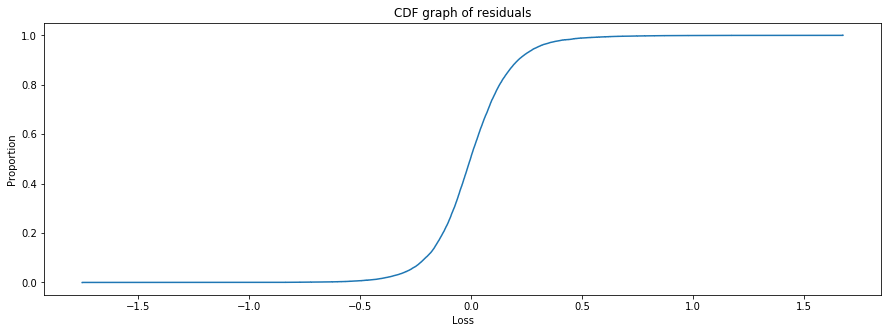

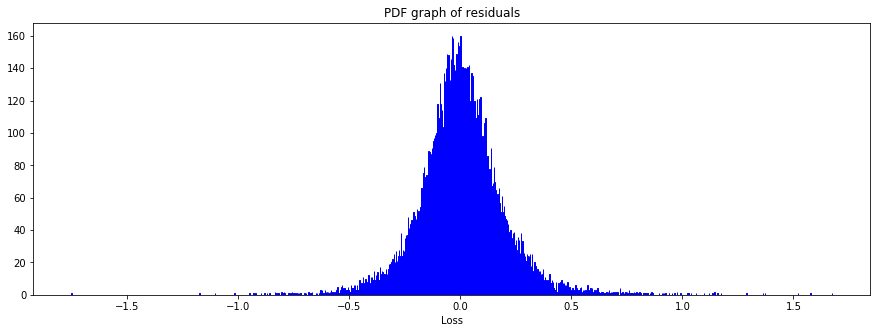

__________________________________________________
r2 score : 0.953228656284531
mse : 0.03331729232978454
---------=======================------------For test data-----------=======================-------------


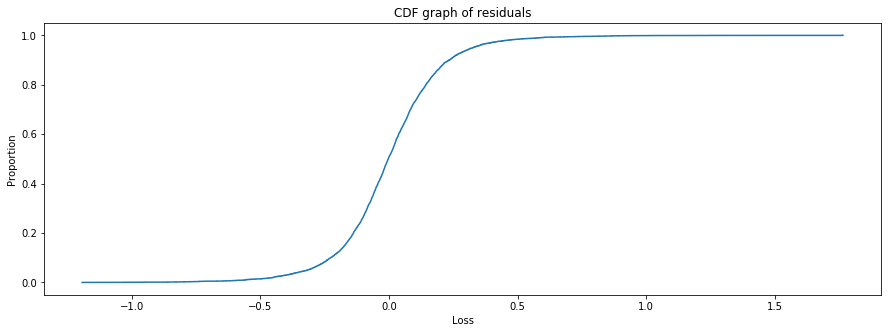

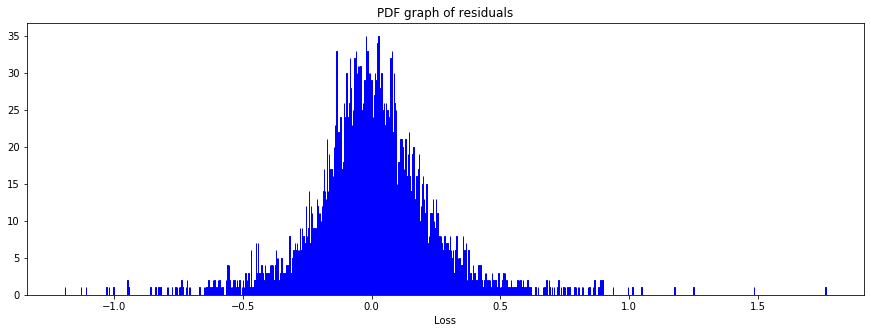

__________________________________________________
r2 score : 0.940924246522673
mse : 0.04328424485162436


In [75]:
print('---------=======================------------For train data----------======================--------------')
plot_loss_distribu(np.log(y_train),y_pred_train)
print('---------=======================------------For test data-----------=======================-------------')
plot_loss_distribu(np.log(y_test),y_pred)


### QQ plot between test target and predicted test target variable

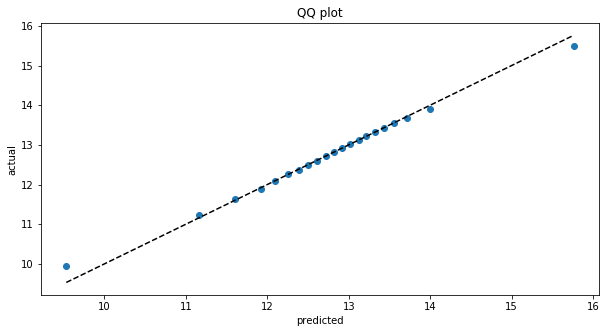

In [85]:

percs = np.linspace(0,100,21)
qn_a = np.percentile(np.log(y_test), percs)
qn_b = np.percentile(y_pred, percs)
plt.figure(figsize=(10,5))
plt.plot(qn_a,qn_b, ls="", marker="o")

x = np.linspace(np.min((qn_a.min(),qn_b.min())), np.max((qn_a.max(),qn_b.max())))

plt.title('QQ plot' ) # plotting cdf of loss
plt.xlabel('predicted')
plt.ylabel('actual')
plt.plot(x,x, color="k", ls="--")

plt.show()

### XGB 

In [73]:
df5.head(1)

Rating       city  Kilometers  Year_of_Purchase   Owner Fuel_Type  \
0    4.00  hyderabad       34854              2010  First     Petrol   

  Transmission      RTO Insurance_Type Month_of_Purchase        Model Company  \
0       MANUAL  RTOAP09        Expired               May  MARUTI ALTO  MARUTI   

  Company_and_year  
0      MARUTI 2010

In [75]:
df5=pd.get_dummies(df5,columns=['city','Year_of_Purchase','Owner','Fuel_Type','Transmission','RTO','Insurance_Type','Month_of_Purchase','Company','Model','Company_and_year'])

In [78]:
X_train, X_test, y_train, y_test = train_test_split(df5, y_train_df, test_size = 0.3,random_state=21)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((22510, 1550), (9648, 1550), (22510,), (9648,))

In [81]:
gsc = GridSearchCV(
        estimator=xgb_model,
        param_grid={#'colsample_bytree' : [0.1, 0.3, 0.4],
            #'gamma': [0.0, 0.1, 0.2],
            'n_estimators':[50,100,150,250],
            'learning_rate': [0.25,0.3,0.35],
            'max_depth': [3,5,7,13],
            'min_child_weight': [3,4,5]
                   },
        cv=3, scoring='r2', verbose=5, n_jobs=7)

In [82]:
grid_result = gsc.fit(X_train, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:  3.2min
[Parallel(n_jobs=7)]: Done  58 tasks      | elapsed: 43.7min
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed: 173.3min
[Parallel(n_jobs=7)]: Done 274 tasks      | elapsed: 321.8min
[Parallel(n_jobs=7)]: Done 432 out of 432 | elapsed: 528.4min finished
C:\Users\santosh\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [83]:
grid_result.best_params_

{'learning_rate': 0.25,
 'max_depth': 5,
 'min_child_weight': 3,
 'n_estimators': 250}

In [84]:
xgb_model =XGBRegressor(Learning_rate=0.25, max_depth=5, min_child_weight=3, n_estimators=250,objective="reg:squarederror", random_state=21)

xgb_model.fit(X_train, y_train)

y_pred_train=xgb_model.predict(X_train)

y_pred = xgb_model.predict(X_test)




C:\Users\santosh\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


---------=======================------------For train data----------======================--------------


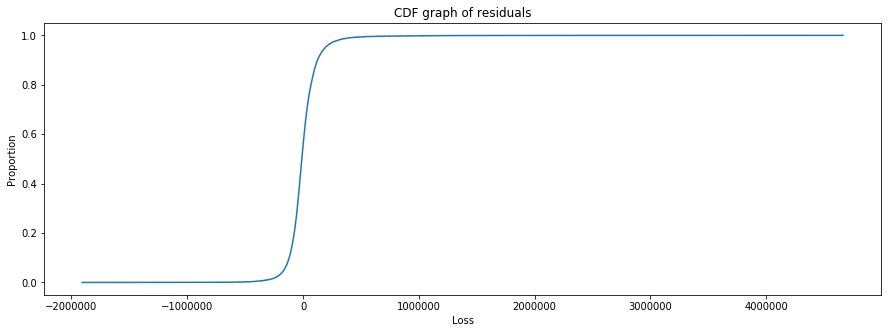

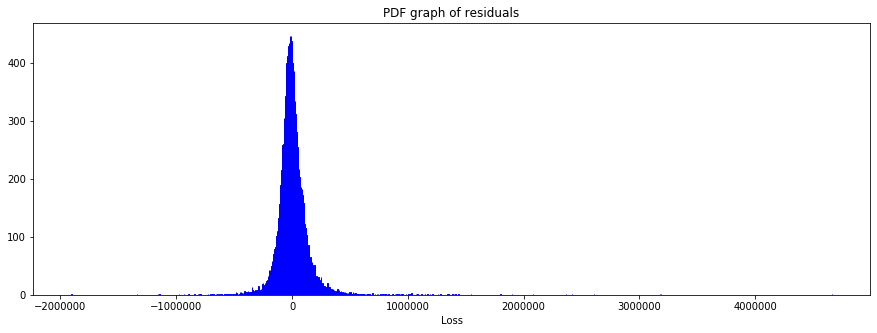

__________________________________________________
r2 score : 0.9015015025814678
mse : 20195743432.178288
---------=======================------------For test data-----------=======================-------------


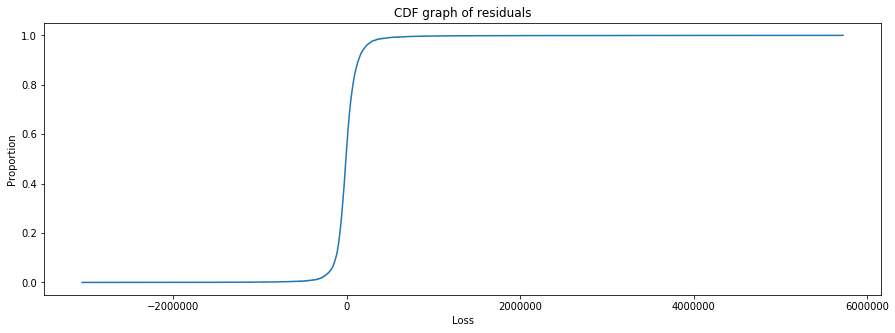

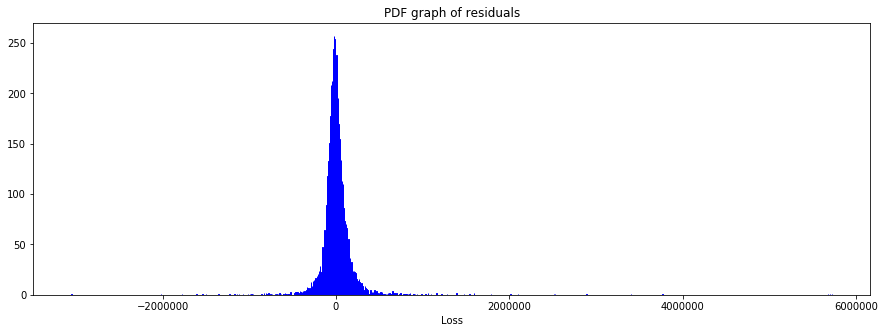

__________________________________________________
r2 score : 0.8031068560080081
mse : 39970992812.94369


In [85]:
print('---------=======================------------For train data----------======================--------------')
plot_loss_distribu(y_train,y_pred_train)
print('---------=======================------------For test data-----------=======================-------------')
plot_loss_distribu(y_test,y_pred)

## Comparision

In [193]:
### http://zetcode.com/python/prettytable/

from prettytable import PrettyTable


conclusion= PrettyTable()
conclusion.field_names = ["Model", "Part", "train_r2 score", "test_r2 score"]

conclusion.add_row(["Linear regression", "Part 1", 0.9, 0.77])
conclusion.add_row(["Decision tree regressor", "Part 1", 0.49, 0.44])
conclusion.add_row(["Catboost regressor", "Part 1", 0.69, 0.63])
conclusion.add_row(["----------------------------", "--------------", '-----------', '------------'])
conclusion.add_row(["Decision tree regressor", "Part 2", 0.53, 0.48])
conclusion.add_row(["Random forest regressor", "Part 2", 0.59, 0.53])

conclusion.add_row(["----------------------------", "--------------", '-----------', '------------'])
conclusion.add_row(["Catbot regressor", "Part 3", 0.84, 0.80])



conclusion.add_row(["----------------------------", "--------------", '-----------', '------------'])
conclusion.add_row(["Catbot regressor", "Part 4", 0.90, 0.83])
conclusion.add_row(["XGB regressor", "Part 4", 0.97, 0.82])


conclusion.add_row(["----------------------------", "--------------", '-----------', '------------'])
conclusion.add_row(["Catbot regressor", "Part 5", 0.90, 0.84])
conclusion.add_row(["XGB regressor", "Part 5", 0.90, 0.80])
print(conclusion)

+------------------------------+----------------+----------------+---------------+
|            Model             |      Part      | train_r2 score | test_r2 score |
+------------------------------+----------------+----------------+---------------+
|      Linear regression       |     Part 1     |      0.9       |      0.77     |
|   Decision tree regressor    |     Part 1     |      0.49      |      0.44     |
|      Catboost regressor      |     Part 1     |      0.69      |      0.63     |
| ---------------------------- | -------------- |  -----------   |  ------------ |
|   Decision tree regressor    |     Part 2     |      0.53      |      0.48     |
|   Random forest regressor    |     Part 2     |      0.59      |      0.53     |
| ---------------------------- | -------------- |  -----------   |  ------------ |
|       Catbot regressor       |     Part 3     |      0.84      |      0.8      |
| ---------------------------- | -------------- |  -----------   |  ------------ |
|   